## Multimodal modelling
The dataset is from an online discussion forum where members make posts about random sports topics and people engage in the topics, expressing their opinions as they see fit. The dataset comprises of post ID, post topic, the target audience, post time, post rating, total number of replies recorded on the post as of the time the data was fetched, the time of first reply on the post, the time of last reply on the post as of when the data was fetched and lastly a collection of all the text replies on the data of time the data was fetched.   

#### Objective 
**Binary classification** of `High-engagement post vs Low-engagement post`      
I will be doing a binary classification of with dataset with the aim of classifying a post as either a high-engagment post or low-engagement post. The dataset that meet the requirements below will be tagged as high engagement post and the rest will be classed as low engagement post. The criteria for a high engagment post are:
1. total replies are above the 70th percentile and
2. total words in reply are above the 70th percentile of total reply words


##### Feature engineering and modelling
The dataset comprises of numerical and text features. The data classification will be modelled in three parts: (1) numerical/categorical features only (2) text features only (3) numerical and text features combined.   
I will compare the three types of dataset features to determine which one performed best at classifying the data. 

For the classification model, I will be using only these two models (1) Logistic regression and (2) Linear SVC. These models are chosen because they have interpretable coefficients, can handle high dimensionalities and are comparable.

##### Metrics
The model performances shall be evaluated side by side with precision, recall, f1 scores and confusion matrix.  These metrics will be used to answer the questions: (1) did the text features improve performance and vice versa (2) if yes, how? (3) if not, why?

##### Conclusion
Following the modelling of the data using numeric features, text features and combined features, the results show that numeric features only was better at classifying the data alone than when combined with text features.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

In [2]:
df = pd.read_csv('sports_discussion.csv')
df.head()

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply
0,334861113.0,Winning pitcher,R,7:45,NaN,0,NaN,NaN,NaN
1,334860171.0,The Three Greatest Martial Artists ever!,R,2025-05-23 23:51,-7,2,0:09,4:46,Bruce Lee never held any black belt** Chuck wa...
2,334858648.0,UFL Week 9,R,2025-05-23 17:11,-5,0,NaN,NaN,NaN
3,334857214.0,"so..angel reese is 6'3""...she is 4 for 19 when",R,2025-05-23 13:49,-5,4,2025-05-23 15:50,2025-05-23 21:20,"And? §** no and..can u add something cogent, m..."
4,334852374.0,"Caroline was the fav last night ,please explain",R,2025-05-23 06:20,NaN,1,2025-05-23 06:25,2025-05-23 06:25,Bobrovsky shutout imagine that §**


In [3]:
df.shape

(60000, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                41410 non-null  float64
 1   post              41410 non-null  object 
 2   audience          41410 non-null  object 
 3   post_time         41410 non-null  object 
 4   rating            10740 non-null  object 
 5   total_reply       60000 non-null  int64  
 6   time_first_reply  28424 non-null  object 
 7   time_last_reply   28424 non-null  object 
 8   all_reply         28424 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.1+ MB


In [5]:
df.isnull().sum()

ID                  18590
post                18590
audience            18590
post_time           18590
rating              49260
total_reply             0
time_first_reply    31576
time_last_reply     31576
all_reply           31576
dtype: int64

Based on the quick data exploration, there are quite significant number of empty rows in the data that would require cleaning.  Each column of the dataset will be cleaned appropriately and if there is need, the empty rows will filled appropriately or dropped.  
One caveat though is that, this dataset is based on the post column where someone has made a post. So every other column in the dataset is dependent on the post column. So if a row has all the columns filled but there is no post text in, it breaks the assumption that the row is related to the post text. Therefore for this modelling, every data preprocessing will be based on a post and i will not be considering empty strings in the post column. 

In [6]:
## checking rows where the post feature is empty or nan
empty_post_feature = df.loc[df['post'].isnull()]
empty_post_feature.head(5)

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply
143,NaN,NaN,NaN,NaN,NaN,5,2025-04-19 03:33,2025-04-20 06:31,FireTomlin wont bite on bum Jalen Melrose §** ...
280,NaN,NaN,NaN,NaN,NaN,3,2025-03-12 05:13,2025-03-12 05:23,Week 9 §** Micah say no more rook QB all eggs ...
404,NaN,NaN,NaN,NaN,NaN,4,2025-02-09 06:52,2025-02-09 07:51,Gotta get that 3peat! §** Chief Manyhandles §*...
487,NaN,NaN,NaN,NaN,NaN,5,2025-01-26 20:01,2025-01-27 05:02,"If the Chiefs can ""Cook"" ""Buffalo"" at home,** ..."
635,NaN,NaN,NaN,NaN,NaN,1,2024-12-31 18:16,2024-12-31 18:16,Canada 0-1 USA 2nd 12m §**


In [7]:
empty_post_feature.isnull().sum()

ID                  18590
post                18590
audience            18590
post_time           18590
rating              18590
total_reply             0
time_first_reply    13531
time_last_reply     13531
all_reply           13531
dtype: int64

One clear pattern for rows without post is that they have only data regarding the reply. based on my objective, all these rows will be dropped. 

In [8]:
# dropping all rows without a post string data
post_df = df.dropna(subset=['post'], axis=0)
post_df = post_df.reset_index(drop=True)

In [9]:
post_df.isnull().sum()

ID                      0
post                    0
audience                0
post_time               0
rating              30670
total_reply             0
time_first_reply    18045
time_last_reply     18045
all_reply           18045
dtype: int64

In [10]:
post_df.shape

(41410, 9)

removing rows without post string data significantly cleaned most of the columns and whats left are columns that have to do with reply and rating. I will explore the reply columns first. 

In [11]:
## inspecting rows with empty reply features rows
reply_bool = (post_df['time_first_reply'].isnull()) | (post_df['time_last_reply'].isnull()) | (post_df['all_reply'].isnull())
empty_reply = post_df.loc[reply_bool]
empty_reply.head()

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply
0,334861113.0,Winning pitcher,R,7:45,NaN,0,NaN,NaN,NaN
2,334858648.0,UFL Week 9,R,2025-05-23 17:11,-5,0,NaN,NaN,NaN
6,334849157.0,Karlie Irsay-Gordon--new owner of the Colts!!,R,2025-05-22 15:58,NaN,0,NaN,NaN,NaN
11,334833877.0,MR BEAST GAMES SEASON 2 APPLICATION,R,2025-05-21 08:26,-1,0,NaN,NaN,NaN
13,334824472.0,Im looking for team batting averages for,R,2025-05-20 09:09,-9,0,NaN,NaN,NaN


One thing that has stood out on the empty reply rows is that they do not have a reply to the post. If this is the case for all the empty reply related features, then they are not missing data and do not need cleaning, rather it simply means the post has no reply.    
However this assumption needs to be verified in two ways.  
1. All rows where total reply is zero (0) must have no text in 'all_reply' column.
2. These three columns must all be NaN: time_first_reply, time_last_reply and all_reply.

In [12]:
# checking all_reply and total_reply column
## Assumption 1 condition
# rows that break the assumption of zero total reply and all reply is NaN
no_reply_bool = (post_df['all_reply'].isnull()) & (post_df['total_reply'] != 0)
post_df.loc[no_reply_bool]

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply


In [13]:
## second way of checking condition 1 
## This applies mostly to total-reply column ensuring that total counts are accurate and not wrong. 
## where there is data in reply but count is zero, that will be investigated further because it could be an error. 
total_count_bool = (post_df['total_reply'] == 0) & (post_df['all_reply'].notnull())
post_df.loc[total_count_bool]

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply


The condition 1 is validated in two way. first that all NaN rows in all_reply have zero total_reply count. Second is that all rows where all_reply column is not null do not have a zero tota_reply count. If this second validation method failed, it would be that there is potential error in the total_reply vs all_reply column. 

In [14]:
## checking for the second condition. 
## Assumption condition 2
reply_null_bool = (post_df['time_first_reply'].isnull()) & (post_df['time_last_reply'].isnull()) & (post_df['all_reply'].isnull())
post_df.loc[reply_null_bool].shape

(18045, 9)

In [15]:
## verifying total empty rows in reply related features. 
print('Total number of rows with where total reply is zero is %0.0f ' % (post_df.loc[post_df['total_reply']==0].shape[0]))

post_df[['time_first_reply', 'time_last_reply', 'all_reply']].isnull().sum()

Total number of rows with where total reply is zero is 18045 


time_first_reply    18045
time_last_reply     18045
all_reply           18045
dtype: int64

Following the verification of the two conditions for the reply related columns,it therefore means that the null rows in time_first_reply, time_last_reply and all_reply are rows where no reply has been recorded and therefore are correct as they are.   
Final column to look at will be the rating column. 

In [16]:
# checking the unique values in the rating columns. 
unique_rating = post_df['rating'].unique()
unique_rating

array([nan, '-7', '-5', '+5', '-5+5', '-1', '-10', '-9', '-15', '-14+5',
       '-12', '-4', '-3', '+25', '+6', '-3+3', '+3', '-10+5', '-10+2',
       '+1', '-6', '-1+3', '-18', '-2', '+2', '-6+3', '-8+5', '-5+10',
       '-8', '-25', '-17+1', '-12+5', '+10', '-4+2', '+4', '-10+9', '+8',
       '-8+3', '-1+1', '-15+5', '-15+13', '-4+3', '-16', '-13', '-1+5',
       '-10+19', '-13+5', '-4+1', '-8+2', '-10+3', '-3+2', '-10+1',
       '-5+2', '-2+5', '-5+1', '+7', '-18+4', '-17', '-13+3', '+15',
       '-1+4', '-8+7', '-11', '-10+10', '-3+5', '+20', '-8+4', '-5+3',
       '-3+20', '-4+5', '-9+5', '-14', '+13', '+19', '-2+3', '-5+12',
       '+11', '-20+5', '-26+3', '-5+17', '-2+2', '-11+5', '-18+5', '-2+1',
       '-25+5', '-1+2', '+9', '+24', '+16', '-10+8', '-3+10', '-17+5',
       '-7+2', '-7+10', '-1+12', '-22+15', '-28+2', '-5+7', '-5+8',
       '-3+1', '-8+10', '-1+10', '-15+2', '-13+2', '-20', '-1+7', '-5+15',
       '-6+5', '-14+21', '-10+7', '+14', '+21', '-11+20', '-21', '-6+10'

The rating column has an interesting pattern. There are two unique numbers in the post, either a positive or negative value. Because this is a rating column and there is no further information about how this rating was done, I will be using my best judgement to engineer this column. I will take the positive number as the total upvotes a post has and negative number as the total downvotes a post has. 
1. The column will be turned to numbers and where positive and negative numbers are used, both numbers will be added arithmetically to get the finaly value which will be the rating. Example '-7+7' will be -7+7 = 0.  if no number is found, the post rating will be zero (0).
2. A new column will be added called total_votes. This will the sum of upvote and downvotes on a post, such that a rating with '-7+7' will have a total vote of 14.


In [17]:
### function def. 
def rating_clean(rate):
    
    if rate is np.nan:
        return 0, 0  # rating and total_vote as 0 and 0 tuple

    rate = str(rate)
    if re.search(r'\+', rate) and re.search(r'-', rate):
        votes = rate.split('+')  #splitting the positive sign to keep the negative sign since all double ratings use negative first
        rate = int(votes[0]) + int(votes[1])
        total_vote = abs(int(votes[0])) + int(votes[1])
        return rate, total_vote # return the computed rating and votes
        
    return int(rate), abs(int(rate))  # return int of rating and abs value as total

In [18]:
## cleaning the rating column
post_df.loc[:,'all_vote'] = post_df['rating'].apply(rating_clean)
post_df.loc[:,'votes'], post_df.loc[:,'total_vote'] = zip(*post_df['all_vote'])

In [19]:
post_df.iloc[6:11]

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply,all_vote,votes,total_vote
6,334849157.0,Karlie Irsay-Gordon--new owner of the Colts!!,R,2025-05-22 15:58,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
7,334846392.0,Irsay died. §,R,2025-05-22 11:41,+5,2,2025-05-22 13:48,2025-05-23 22:09,Good 👍** did lots of drugs his entire life.He ...,"(5, 5)",5,5
8,334841389.0,"Goes to sleep its 3-1 ,wakes up its 6-3 Stars",R,2025-05-22 02:50,-5,1,2025-05-22 05:20,2025-05-22 05:20,Edmonton has major holes in their game.**,"(-5, 5)",-5,5
9,334838997.0,"Just curious.....what kind of ""script"" has the",R,2025-05-21 16:24,-5+5,6,2025-05-21 20:19,2025-05-22 12:23,Indiana Pacers.. W....** Knicks win in 7 games...,"(0, 10)",0,10
10,334834139.0,Tush Push lives on!,R,2025-05-21 08:42,-5+5,18,2025-05-21 09:09,7:56,I thank the tariffs for that!!! §** its like ...,"(0, 10)",0,10


**Transforming the time columns**   
The dataset timeline spans from June 2011 to May 2025 and the data is indexed from the most recent post (index 0) to the oldest post. A look at the time digits of the first 10 rows  and their corresponding dates will prove this. 
Also, I will verify this assumption by comparing each row with previous row going down the post_time.   
The first row of the post_time column has only time recorded while the remaining first 4 rows (index 1 to 4) have time and date values. Looking at the time, it shows that posts started from 06.20 to 23.51 of 23-05-2025.  Therefore the next post date should be 24-05-2025 for the row index 0. Using the above assumption and to make it easy for comparison, I will update the time in the first row with the date.

In [20]:
### updating the posttime of first row
post_df.loc[0, 'post_time'] = '2025-05-24 07:45'  
post_df['post_time'].head(10)

0    2025-05-24 07:45
1    2025-05-23 23:51
2    2025-05-23 17:11
3    2025-05-23 13:49
4    2025-05-23 06:20
5    2025-05-22 16:22
6    2025-05-22 15:58
7    2025-05-22 11:41
8    2025-05-22 02:50
9    2025-05-21 16:24
Name: post_time, dtype: object

In [21]:
# converting to datetime 
post_df.loc[:, 'post_time'] = pd.to_datetime(post_df['post_time'])
post_df['post_time'] = post_df['post_time'].astype('datetime64[ns]')

In [22]:
### verifying the post time
time_bool = post_df['post_time'] > post_df['post_time'].shift(1)

# if the time of the post is ordered as I hypothesized, then the sum of the timebool shall be zero meaning there is value that is True
print(time_bool.sum())

2


Two rows did not meet the hypothesis that the data was collected in time order. I will inspect these rows and decide what happens

In [23]:
## rows that did not meet the time order hypothesis
post_df[time_bool]

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply,all_vote,votes,total_vote
2364,329737802.0,Who are the Warriors giving up,R,2024-02-05 18:17:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
7054,320714558.0,Apparently the USFL does a draft?,R,2022-02-23 13:04:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0


In [24]:
## data between row 2364
post_df.iloc[2362:2367]

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply,all_vote,votes,total_vote
2362,329738679.0,Niners getting screwed by soft practice field,R,2024-02-05 20:23:00,-5,7,2024-02-05 22:56,2024-02-06 11:24,They prepare for a year and** NFL dont make mo...,"(-5, 5)",-5,5
2363,329737799.0,Who are the Warriors giving up,R,2024-02-05 18:16:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
2364,329737802.0,Who are the Warriors giving up,R,2024-02-05 18:17:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
2365,329736117.0,"Decent bet on LaClippers - 4 tonight, imho",R,2024-02-05 15:44:00,NaN,3,2024-02-05 16:53,2024-02-06 02:56,eric beinemy canned by Commandos** Underwhelmi...,"(0, 0)",0,0
2366,329735444.0,Brock is playing for The Hardware! (sunday) §,R,2024-02-05 14:40:00,-5,7,2024-02-05 14:41,2024-02-05 17:32,"Niners win, Brock stars, the Swifties fall** T...","(-5, 5)",-5,5


In [25]:
## data between row 7054
post_df.iloc[7052:7057]

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply,all_vote,votes,total_vote
7052,320714824.0,Good rundown about sports betting in US states,R,2022-02-23 13:18:00,NaN,4,2022-02-23 13:21,2022-02-23 14:35,What do WV & TN do with their gambling $$$?** ...,"(0, 0)",0,0
7053,320714498.0,Apparently the USFL does a draft?,R,2022-02-23 13:03:00,NaN,1,2022-02-25 06:43,2022-02-25 06:43,is the USFL considered AA or AAA? §**,"(0, 0)",0,0
7054,320714558.0,Apparently the USFL does a draft?,R,2022-02-23 13:04:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
7055,320714350.0,2021-22 Premier league 2/23,R,2022-02-23 12:56:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
7056,320713440.0,"fuck getting it caught in ur zipper,",R,2022-02-23 12:15:00,NaN,3,2022-02-23 12:29,2022-02-23 14:40,Shoulda peed ahead of time. §** Well if he was...,"(0, 0)",0,0


Looking at the post times of the data just before rows 2364 and 7054, you will obviously notice that the differences between these previous post time and the current row post time is only 1 minute. 18:16 versus 18:17 and 13:03 versus 13:04. Technically by comparisons level, the dataset failed to meet the assumption but datawise, the information is not wrong.  
However, one more thing stands very obvious, **the data is a duplicate of the previous column**. The only difference is in the ID number and in the total_reply column.   
If we set aside computing for once and apply human reasoning, we can assume that the post made the post twice within the same time frame. The data with a reply will be retained and the one without reply will be dropped while for rows 2363 and 2364, one will be dropped. 

In [26]:
## dropping the indexes 
post_df = post_df.drop(index=[2364, 7054])
display(post_df.iloc[2363:2365])
print()
post_df.iloc[7053:7055]

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply,all_vote,votes,total_vote
2363,329737799.0,Who are the Warriors giving up,R,2024-02-05 18:16:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
2365,329736117.0,"Decent bet on LaClippers - 4 tonight, imho",R,2024-02-05 15:44:00,NaN,3,2024-02-05 16:53,2024-02-06 02:56,eric beinemy canned by Commandos** Underwhelmi...,"(0, 0)",0,0


,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply,all_vote,votes,total_vote
7055,320714350.0,2021-22 Premier league 2/23,R,2022-02-23 12:56:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
7056,320713440.0,"fuck getting it caught in ur zipper,",R,2022-02-23 12:15:00,NaN,3,2022-02-23 12:29,2022-02-23 14:40,Shoulda peed ahead of time. §** Well if he was...,"(0, 0)",0,0


In [27]:
## resetting the index
post_df.reset_index(drop=True, inplace=True)

In [28]:
## Looking at the audience columns 
post_df['audience'].unique()

array(['R'], dtype=object)

In [29]:
post_df['audience'].value_counts()

audience
R    41408
Name: count, dtype: int64

The audience does not add any additional information to the data. it is a redundant column just like the column Id. This will be dropped subsequently. 

#### Cleaning the Text columns (post and all_reply)
The text columns contain both English words, symbols and emojis.  Therefore the text will be cleaned to keep only the English vocabularies.  
For the cleaning, I would like to keep only a single semantic. This will be only hyphenated words. Personal pronouns with apotrophy will be stripped. 

In [30]:
#function definition 
def words(word):
    pattern = re.compile(r'[^\W\d_]+(?:[-][^\W\d_]+)*|\d+', flags=re.UNICODE)
    if isinstance(word, float):
        return word
    
    word = unicodedata.normalize('NFKC', word)
    text = pattern.findall(word)
    if len(text) < 1:
        return np.nan

    return ' '.join(text).lower()

## Cleaning the columns 

post_df['post'] = post_df['post'].apply(words)
post_df['all_reply'] = post_df['all_reply'].apply(words)


In [31]:
post_df.head()

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply,all_vote,votes,total_vote
0,334861113.0,winning pitcher,R,2025-05-24 07:45:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
1,334860171.0,the three greatest martial artists ever,R,2025-05-23 23:51:00,-7,2,0:09,4:46,bruce lee never held any black belt chuck was ...,"(-7, 7)",-7,7
2,334858648.0,ufl week 9,R,2025-05-23 17:11:00,-5,0,NaN,NaN,NaN,"(-5, 5)",-5,5
3,334857214.0,so angel reese is 6 3 she is 4 for 19 when,R,2025-05-23 13:49:00,-5,4,2025-05-23 15:50,2025-05-23 21:20,and no and can u add something cogent mr shang...,"(-5, 5)",-5,5
4,334852374.0,caroline was the fav last night please explain,R,2025-05-23 06:20:00,NaN,1,2025-05-23 06:25,2025-05-23 06:25,bobrovsky shutout imagine that,"(0, 0)",0,0


One last thing about the texts following cleaning is to reinspect the post column again. This is because it is likely that some post text were filtered out as invalid words which will result in the row becoming empty. If that is the case, the corresponding rows need to be dropped because the objective of the model in hinged on the post column.

In [32]:
## number of new null rows in post.
post_df['post'].isnull().sum()

np.int64(11)

In [33]:
post_df[post_df['post'].isnull()] ## viewing the null post rows

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply,all_vote,votes,total_vote
2542,329471898.0,NaN,R,2024-01-14 16:08:00,NaN,1,2024-01-14 16:16,2024-01-14 16:16,bet rodgers is pissed right now,"(0, 0)",0,0
4882,324858527.0,NaN,R,2022-12-13 09:57:00,NaN,1,2022-12-13 11:16,2022-12-13 11:16,seems as if producer peter guber invested in ws,"(0, 0)",0,0
7671,319986153.0,NaN,R,2022-01-09 11:58:00,NaN,1,2022-01-09 12:08,2022-01-09 12:08,no offense but you guys really fuckin suck,"(0, 0)",0,0
10854,309794954.0,NaN,R,2020-10-30 12:50:00,+2,1,2020-10-31 13:24,2020-10-31 13:24,baseball season should cut in half,"(2, 2)",2,2
14256,294770254.0,NaN,R,2018-10-11 01:50:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
33741,218017637.0,NaN,R,2012-08-15 15:05:00,-5,1,2012-08-15 15:36,2012-08-15 15:36,so in your world,"(-5, 5)",-5,5
35443,209529420.0,NaN,R,2012-03-25 15:56:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
36227,206348682.0,NaN,R,2012-02-03 12:30:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
36230,206348589.0,NaN,R,2012-02-03 12:29:00,NaN,0,NaN,NaN,NaN,"(0, 0)",0,0
38197,200517019.0,NaN,R,2011-11-04 15:36:00,NaN,1,2011-11-04 16:10,2011-11-04 16:10,answer,"(0, 0)",0,0


In [34]:
null_post_index = post_df[post_df['post'].isnull()].index
post_df = post_df.drop(index=null_post_index)

post_df = post_df.reset_index(drop=True)

### Feature Engineering
Now that all the columns have been sanitized, the next stage will be drop redundant columns like ID, audience, time_first_reply, time_last_reply, rating and all_vote.    Ordinarily, the next thing would have been exploration and visualisations. However, the only numerical columns available at the moment are votes, total_vote and total_reply columns.  These three columns will not give true picture of the dataset because there are still a lot more information to be generated from the rest of the columns like month, day, hour, year, total words in post, etc.  
Therefore, I will engineer these columns first and then proceed with visualisations and explorations.

In [35]:
#dropping redundant columns
final_df = post_df.drop(['ID', 'audience',  'time_first_reply', 'time_last_reply', 'rating', 'all_vote'], axis='columns')

## checking there are no more dupllcates following column drops
duplicates = final_df.duplicated().sum()
duplicates

np.int64(10)

In [36]:
## viewing the duplicates
duplicated = final_df.duplicated(keep=False)
final_df[duplicated]

,post,post_time,total_reply,all_reply,votes,total_vote
7963,newstyle,2021-12-17 15:50:00,0,NaN,0,0
7964,newstyle,2021-12-17 15:50:00,0,NaN,0,0
8378,utsa 16 6 utep end of 1 st,2021-11-06 20:15:00,0,NaN,0,0
8379,utsa 16 6 utep end of 1 st,2021-11-06 20:15:00,0,NaN,0,0
9718,dak recovery on schedule,2021-05-24 06:21:00,0,NaN,0,0
9719,dak recovery on schedule,2021-05-24 06:21:00,0,NaN,0,0
10054,niners now have pick 3,2021-03-26 11:26:00,0,NaN,0,0
10055,niners now have pick 3,2021-03-26 11:26:00,0,NaN,0,0
20344,one thing that irks me about baseball the over,2015-10-27 10:47:00,0,NaN,-5,5
20345,one thing that irks me about baseball the over,2015-10-27 10:47:00,0,NaN,-5,5


In [37]:
## dropping duplicates 
final_df = final_df.drop_duplicates(ignore_index=True)

In [38]:
final_df.head()

,post,post_time,total_reply,all_reply,votes,total_vote
0,winning pitcher,2025-05-24 07:45:00,0,NaN,0,0
1,the three greatest martial artists ever,2025-05-23 23:51:00,2,bruce lee never held any black belt chuck was ...,-7,7
2,ufl week 9,2025-05-23 17:11:00,0,NaN,-5,5
3,so angel reese is 6 3 she is 4 for 19 when,2025-05-23 13:49:00,4,and no and can u add something cogent mr shang...,-5,5
4,caroline was the fav last night please explain,2025-05-23 06:20:00,1,bobrovsky shutout imagine that,0,0


In [39]:
## generating more time information data 
final_df['year'] = final_df['post_time'].dt.year
final_df['quarter'] = final_df['post_time'].dt.quarter
final_df['month'] = final_df['post_time'].dt.month
final_df['day_of_week'] = final_df['post_time'].dt.dayofweek
final_df['hour'] = final_df['post_time'].dt.hour
final_df['is_month_start'] = final_df['post_time'].dt.is_month_start.astype(int)
final_df['is_month_end'] = final_df['post_time'].dt.is_month_end.astype(int)
final_df['is_weekend'] = final_df['day_of_week'].isin([5, 6]).astype(int) # Monday = 0 , Sunday=6
final_df['is_businessday'] = final_df['day_of_week'].isin([0,1,2,3,4]).astype(int)


In [40]:
### counting the number of words in the post and reply columns
# IN this counting hyphenated words will be counted as one word
pattern = r'\w\w+(?:[-\w+])*|\d+'

final_df['total_post_words']  = final_df['post'].str.count(pattern)
final_df['total_reply_words'] = final_df['all_reply'].str.count(pattern)

In [41]:
## average words per reply 
final_df['average_reply_words'] = final_df['total_reply_words'] / final_df['total_reply']

### EDA

In [42]:
final_df.head(3)

,post,post_time,total_reply,all_reply,votes,total_vote,year,quarter,month,day_of_week,hour,is_month_start,is_month_end,is_weekend,is_businessday,total_post_words,total_reply_words,average_reply_words
0,winning pitcher,2025-05-24 07:45:00,0,NaN,0,0,2025,2,5,5,7,0,0,1,0,2,NaN,NaN
1,the three greatest martial artists ever,2025-05-23 23:51:00,2,bruce lee never held any black belt chuck was ...,-7,7,2025,2,5,4,23,0,0,0,1,6,14.0,7.0
2,ufl week 9,2025-05-23 17:11:00,0,NaN,-5,5,2025,2,5,4,17,0,0,0,1,3,NaN,NaN


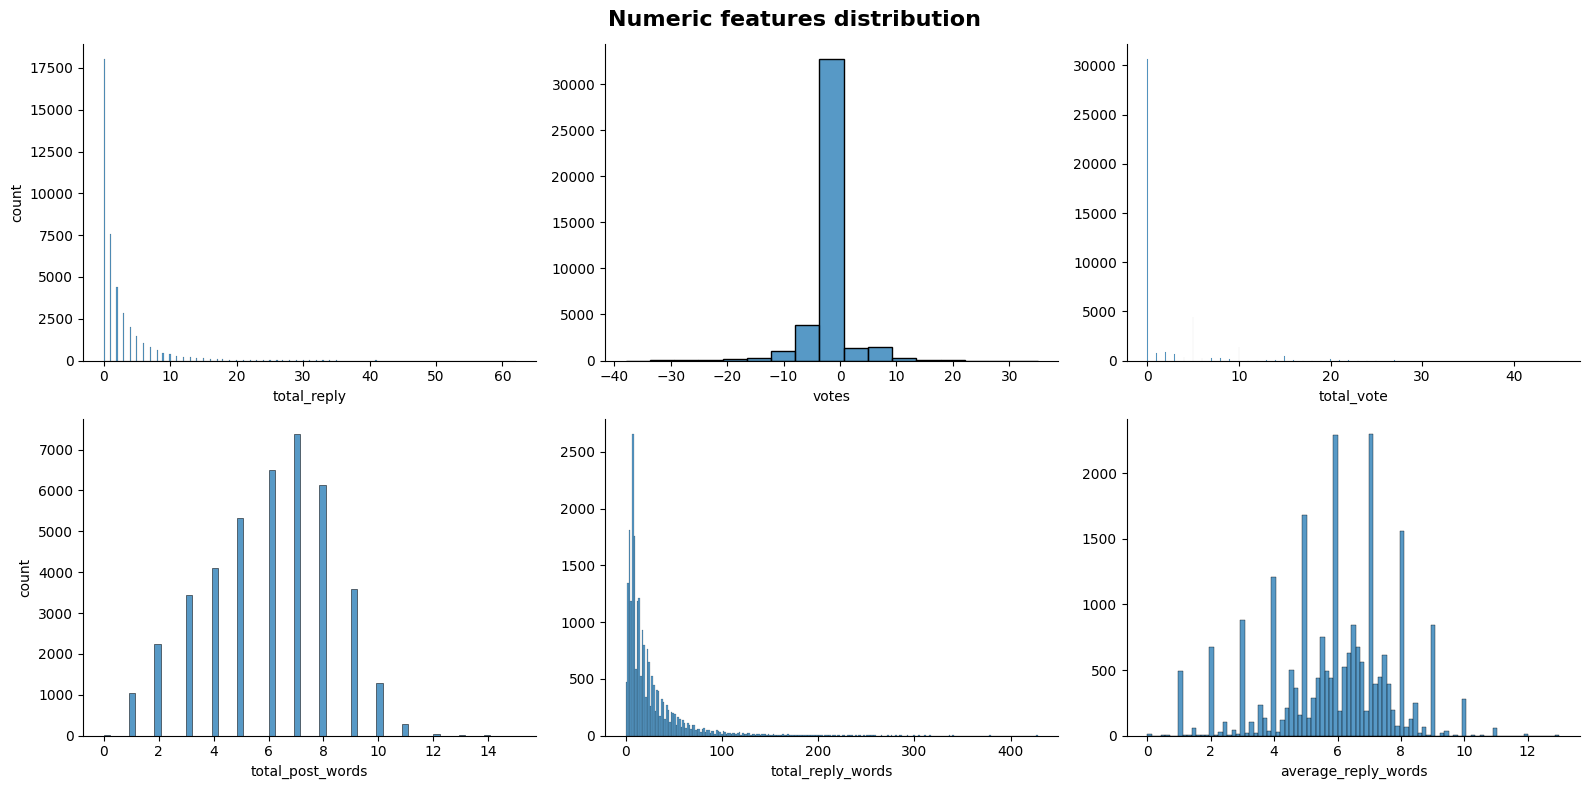

In [43]:
### distribution plots
distributions = ['total_reply', 'votes', 'total_vote', 'total_post_words', 'total_reply_words', 'average_reply_words']

fig, axes = plt.subplots(2, 3, figsize=(16, 8), layout='tight')
plt.suptitle('Numeric features distribution', fontweight='bold', fontsize=16)
axd = axes.ravel()
step=0
for num, column in zip(axd, distributions):
    ax = sns.histplot(data=final_df, x=column, ax=num,)
    ax.set_ylabel('')
    if step in (0, 3):
            ax.set_ylabel('count')
    step += 1
    for pos in 'top right'.split():
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.2)
plt.show()

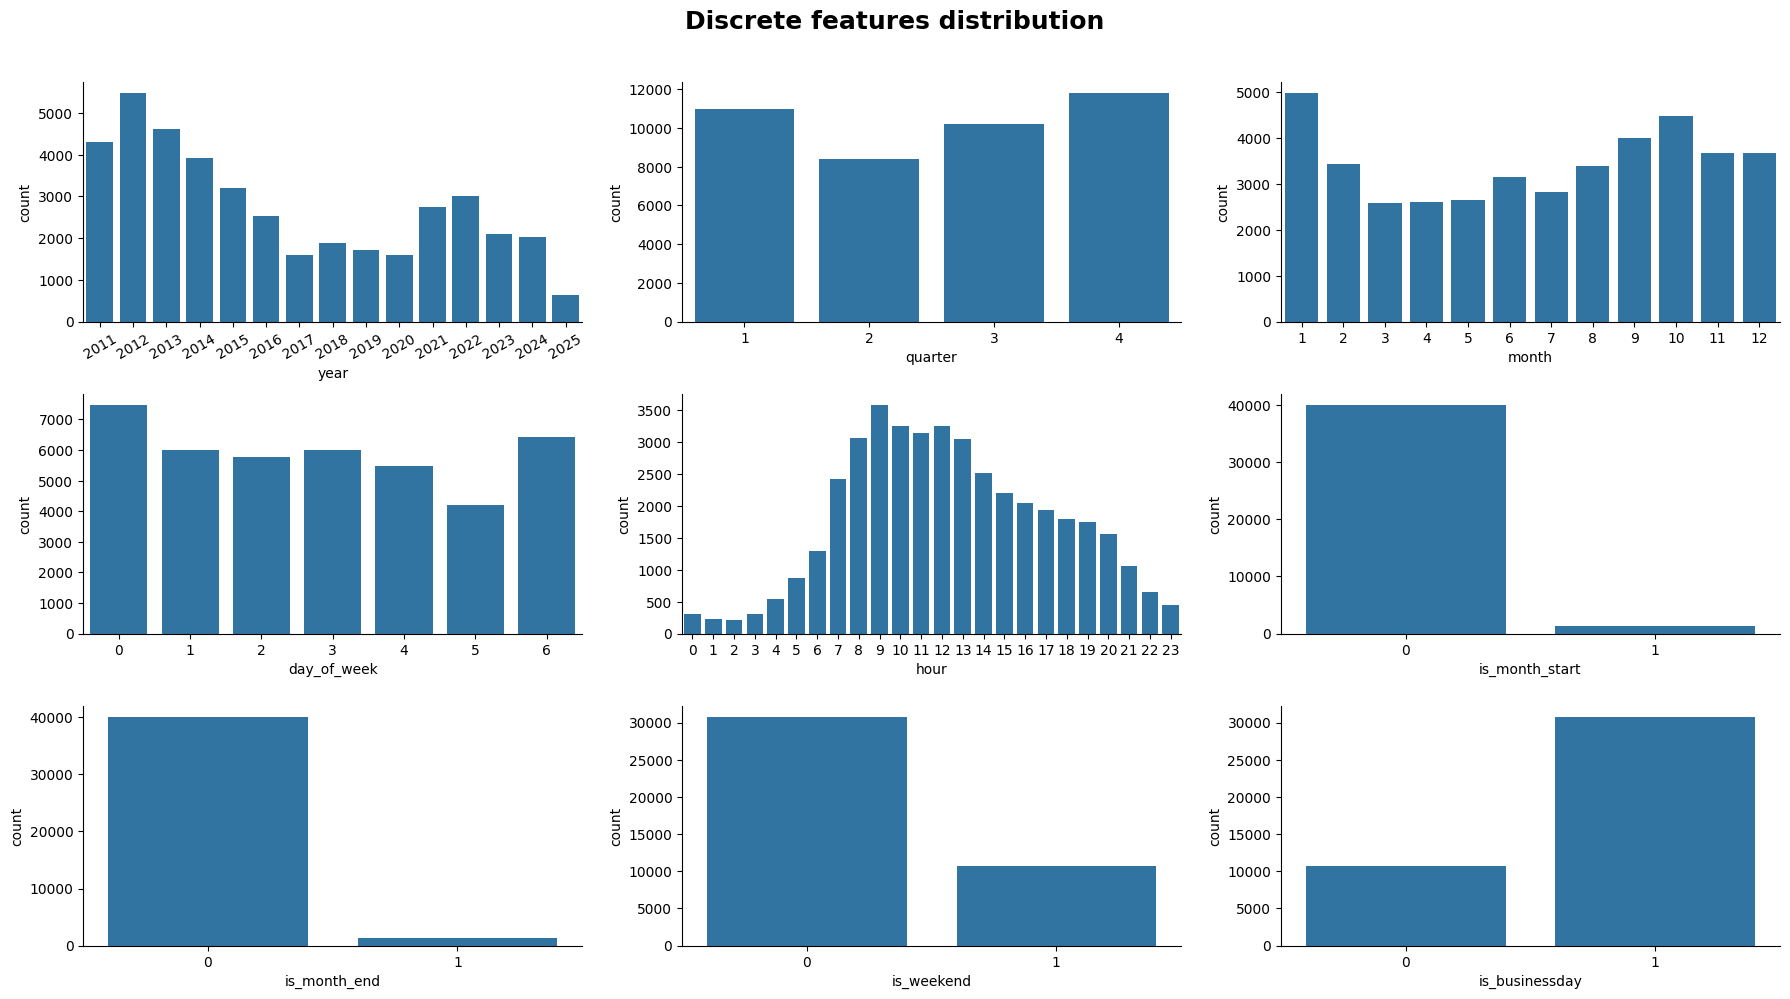

In [44]:
### visualising discrete values
discrete_features = ['year', 'quarter', 'month', 'day_of_week', 'hour', 'is_month_start', 
                     'is_month_end', 'is_weekend', 'is_businessday']

plt.figure(figsize=(18, 12))
for idx, column in enumerate(discrete_features):
    ax =plt.subplot(3, 3, idx+1)
    sns.countplot(data=final_df, x=column, ax=ax)
    for pos in 'top right'.split():
        ax.spines[pos].set_visible(False)
    if column == 'year':
        ax.tick_params(axis='x', which='major',rotation=30)
        

plt.tight_layout()
plt.suptitle('Discrete features distribution', fontweight='bold', fontsize=18)
plt.subplots_adjust(top=0.92, wspace=0.2, hspace=0.3, bottom=0.2)
plt.show()

#### summary of EDA 
The distribution of total_reply, total_vote and total_reply_words are heavily skewed to the right. The total_post_words and votes are mostly normally distributed with most posts having word counts of 6 - 7 words and most posts having zero votes or the sum of upward and downward votes cancel out.  
For the discrete features, the two most obvious patterns is the across the years, the number of posts have steadily declined and also, there appeared to be a little 10-years cycle in the posts but with a downward trend still. One thing to keep in mind though is that between the year 2011 to 2025, there has been an evolution of messaging apps and social media platform, so it is not surprising that some discussion platforms in the early days of social median has declined in engagements.  Another pattern is the hour of the day. Most posts were made in the day time between 7 am to 8 pm with the post reaching the peaks about 9 am and declining after 1 pm. 

### Classifying high vs low engagment posts
Three column features will be used in deciding the top 30% posts. These will be
1. total_reply
2. total_reply_words and

The rows that meet the top 30% of these columns shall be classified as top engagment. I am not including the total_vote column because already the 75 percentile for the column is 1 and min, max are 0 and 45. Including this column will mean that i have to adjust the threshold for the column and this will be inconsistent processing. 

In [45]:
final_df[['total_reply', 'total_reply_words', 'total_vote']].describe()

,total_reply,total_reply_words,total_vote
count,41387.000000,23337.000000,41387.000000
mean,2.271607,24.722286,1.718801
std,3.960339,29.736381,3.858386
min,0.000000,0.000000,0.000000
25%,0.000000,7.000000,0.000000
50%,1.000000,15.000000,0.000000
75%,3.000000,31.000000,1.000000
max,62.000000,428.000000,45.000000


In [46]:
## defining conditions for top posts
top_30_reply = np.nanpercentile(np.asarray(final_df['total_reply']), 70).astype(int)
top_30_words = np.nanpercentile(final_df['total_reply_words'].values, 70).astype(int)
top_30_vote = np.nanpercentile(np.asarray(final_df['total_vote']), 70).astype(int)

display(top_30_reply)
display(top_30_words)
display(top_30_vote)

np.int64(2)

np.int64(26)

np.int64(0)

In [47]:
top_bool = (final_df['total_reply'] > top_30_reply) & (final_df['total_reply_words'] > top_30_words)

top_engagment_posts = final_df[top_bool]
top_engagment_posts.shape

(6831, 18)

In [48]:
final_df.shape

(41387, 18)

In [49]:
top_30_percent_post = top_engagment_posts.shape[0] / final_df.shape[0] * 100

print('The percentage of top engagement post is %0.2f%%' % top_30_percent_post)
print('This corresponds to %0.0f rows of the %1.0f rows in the dataset.' % (top_engagment_posts.shape[0], final_df.shape[0]))

The percentage of top engagement post is 16.51%
This corresponds to 6831 rows of the 41387 rows in the dataset.


**Assigning the high engagement posts** The high-engagement posts will be assigned the integer 1 and low engagement posts will be assigned the integer 0

In [50]:
final_df['engagement'] = 0  #assigning all column as zero first

## isolating high engagments
final_df.loc[top_bool, ['engagement']] = 1


In [51]:
final_df['engagement'].value_counts()

engagement
0    34556
1     6831
Name: count, dtype: int64

In [52]:
final_df.head()

,post,post_time,total_reply,all_reply,votes,total_vote,year,quarter,month,day_of_week,hour,is_month_start,is_month_end,is_weekend,is_businessday,total_post_words,total_reply_words,average_reply_words,engagement
0,winning pitcher,2025-05-24 07:45:00,0,NaN,0,0,2025,2,5,5,7,0,0,1,0,2,NaN,NaN,0
1,the three greatest martial artists ever,2025-05-23 23:51:00,2,bruce lee never held any black belt chuck was ...,-7,7,2025,2,5,4,23,0,0,0,1,6,14.0,7.0,0
2,ufl week 9,2025-05-23 17:11:00,0,NaN,-5,5,2025,2,5,4,17,0,0,0,1,3,NaN,NaN,0
3,so angel reese is 6 3 she is 4 for 19 when,2025-05-23 13:49:00,4,and no and can u add something cogent mr shang...,-5,5,2025,2,5,4,13,0,0,0,1,12,28.0,7.0,1
4,caroline was the fav last night please explain,2025-05-23 06:20:00,1,bobrovsky shutout imagine that,0,0,2025,2,5,4,6,0,0,0,1,8,4.0,4.0,0


### Selecting / Separating Model Data
The data will be separated into text features only and numerica/categorical features only data. Each set of features will be used to model the data separately and then combined to model the data. I will evaluate which set of features performed best at classifying the data.  Logistic regression and Linear SVM will be used. Precision, F1, recall, confusion matrix will be used for metrics.       
One thing to observe is that our dataset is now an imbalanced dataset with 16% classed as 1 and 84% classed as 0. Therefore i will be using the imbalance library for this and model weight balance.   

Another thing to observe is that not all our features in the dataset are valid for modelling. Some features will introduce data leakage to the model and soom features are reduntant. All features relating to reply will be dropped because these information will not be available when a user makes a post. As well the post time column will be dropped as the time features have been extracted already. Finally the features types will be updated appropriately. 

In [53]:
model_df = final_df.drop(['post_time', 'total_reply', 'all_reply', 'votes', 'total_vote', 'total_reply_words', 'average_reply_words', 'engagement'], axis=1)
y = final_df['engagement']

In [54]:
final_df.columns

Index(['post', 'post_time', 'total_reply', 'all_reply', 'votes', 'total_vote',
       'year', 'quarter', 'month', 'day_of_week', 'hour', 'is_month_start',
       'is_month_end', 'is_weekend', 'is_businessday', 'total_post_words',
       'total_reply_words', 'average_reply_words', 'engagement'],
      dtype='object')

In [55]:
model_df.head(3)

,post,year,quarter,month,day_of_week,hour,is_month_start,is_month_end,is_weekend,is_businessday,total_post_words
0,winning pitcher,2025,2,5,5,7,0,0,1,0,2
1,the three greatest martial artists ever,2025,2,5,4,23,0,0,0,1,6
2,ufl week 9,2025,2,5,4,17,0,0,0,1,3


In [56]:
## separating the text features and numerical features
post_df = model_df[['post']]
num_df = model_df.drop('post', axis=1)

## Numerical/ Categorical data
##### Evaluating feature importances


In [57]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (f1_score, 
                            precision_recall_curve,
                            average_precision_score,
                            precision_score,
                            recall_score,
                            ConfusionMatrixDisplay,
                            make_scorer, log_loss
)

In [58]:
cat_features = ['year', 'quarter', 'month', 'day_of_week', 'hour', 'is_month_start',
       'is_month_end', 'is_weekend', 'is_businessday']

num_df[cat_features].astype('category').dtypes

year              category
quarter           category
month             category
day_of_week       category
hour              category
is_month_start    category
is_month_end      category
is_weekend        category
is_businessday    category
dtype: object

In [59]:
## creating a mutual infor score
X = num_df
mi_score = mutual_info_regression(X, y, 
                                  discrete_features=[0,1,2,3,4,5,6,7,8],
                                  random_state=75)

In [60]:
mi_score

array([0.0633888 , 0.        , 0.        , 0.        , 0.00067495,
       0.        , 0.000582  , 0.00122593, 0.00122593, 0.00836235])

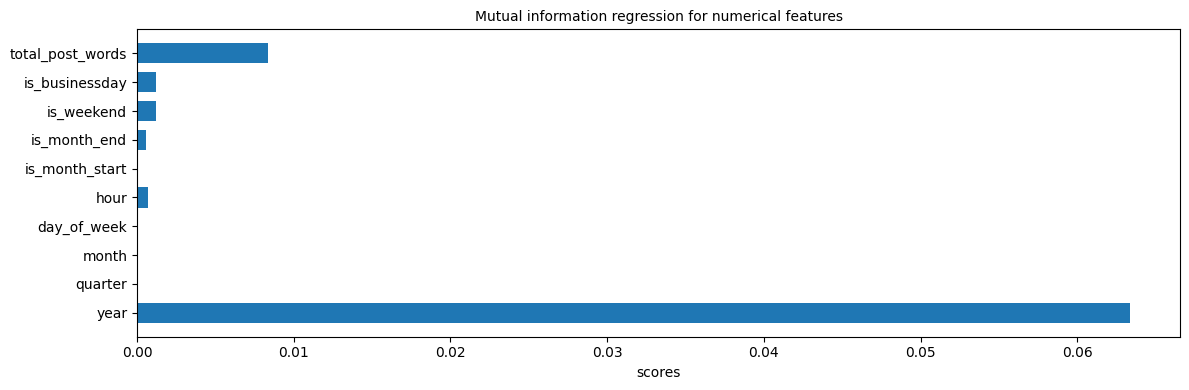

In [61]:
num_columns = num_df.columns
plt.figure(figsize=(12, 4), layout='tight')
plt.barh(width=mi_score, y=num_columns, height=0.7)
plt.title('Mutual information regression for numerical features', fontsize=10)
plt.xlabel('scores')
plt.show()

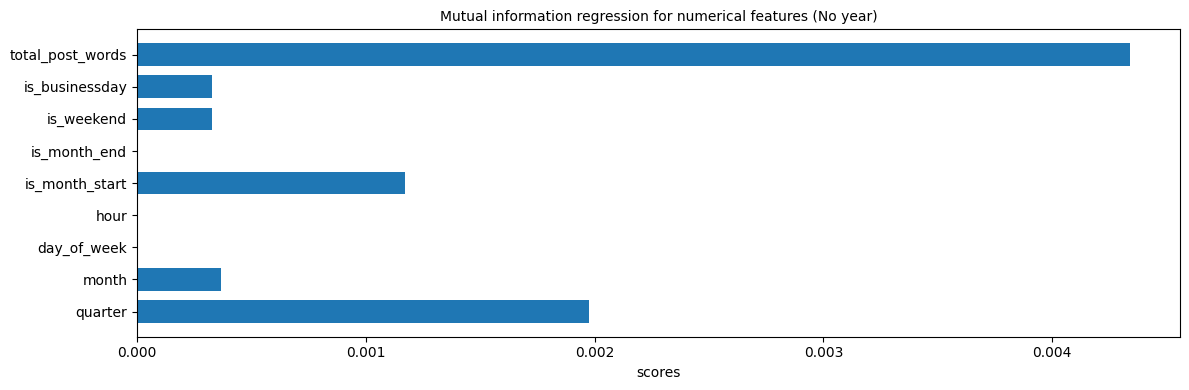

In [62]:
# excluding the year which dominated the data

X_no_year = num_df.drop('year', axis=1)

mi2_score = mutual_info_regression(X_no_year, y, 
                                  discrete_features=[0,1,2,3,4,5,6,7],
                                  random_state=80)

_columns = X_no_year.columns

plt.figure(figsize=(12, 4), layout='tight')
plt.barh(width=mi2_score, y=_columns, height=0.7)
plt.title('Mutual information regression for numerical features (No year)', fontsize=10)
plt.xlabel('scores')
plt.show()

In the first mutual information regression score, the year was very dominant. there are two possible reasons to this, one is that in the EDA plots, the year clearly shows a downward trend with the data and as well, the values for the year are significaantly farther from the rest of the data values although there are only 15 distinct values between 2011 and 2025. The other  features that have shown significant scores without the year in consideration are total_post_words, quarter and is_month_start. total_post_words in EDA also have shown a normal distribution which could account for its significant score.

#### Modeling of numerical features using class balance and SMOTE. 

In [63]:
## splitting train and test data
X = num_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=81)

inner_cv = StratifiedKFold(n_splits=5)

print(X_train.shape, X_test.shape)
print()
print(y_train.value_counts()) 
print()
print(y_test.value_counts())

(31040, 10) (10347, 10)

engagement
0    25917
1     5123
Name: count, dtype: int64

engagement
0    8639
1    1708
Name: count, dtype: int64


In [64]:
#LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True, labels=[0,1])


scale_col = ['total_post_words']

preprocessor = ColumnTransformer([('scaler', StandardScaler(), scale_col)],
                               remainder='passthrough',
                               verbose_feature_names_out=False
                                )

lr_pipeline = Pipeline([('processor', preprocessor),
                         ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=15))]
                        )

lsvc_pipeline = Pipeline([('processor', preprocessor),
                          ('linear_svc', LinearSVC(class_weight='balanced', random_state= 15))]
                        )



logistic_r_params = {'logistic_regression__C': [0.1, 0.5, 1.0, 2.0],
             'logistic_regression__penalty' : ['l2'], 
             'logistic_regression__solver': ['lbfgs', 'newton-cholesky'],
             'logistic_regression__max_iter': [1000, 5000]
            }

                

lsvc_params = [
            # L2 regularisation
            {'linear_svc__penalty': ['l2'],
               'linear_svc__C': [0.1, 0.5, 1.0, 2.0],
               'linear_svc__max_iter':[1000, 2500,  5000],
               'linear_svc__loss': ['hinge', 'squared_hinge']
              }, 
            # using L1 reg
            {'linear_svc__penalty': ['l1'],
               'linear_svc__C': [0.1, 0.5, 1.0, 2.0],
               'linear_svc__max_iter':[1000, 2500,  5000],
               'linear_svc__loss': ['squared_hinge']
              }
]


In [65]:
# ### parameter search logistic regression
lr_search = GridSearchCV(estimator=lr_pipeline,
                         param_grid=logistic_r_params,
                         scoring='neg_log_loss',
                         cv=inner_cv,
                         refit=False,
                         n_jobs= -1)

lr_search.fit(X_train, y_train)

lr_results = pd.DataFrame(lr_search.cv_results_)
best_idx = lr_results['rank_test_score'].idxmin()
best_lr_params = lr_results.loc[best_idx, 'params']
   

best_lr_params['logistic_regression__class_weight'] = 'balanced'
best_lr_params['logistic_regression__random_state'] = 15

best_lr_params

{'logistic_regression__C': 0.1,
 'logistic_regression__max_iter': 5000,
 'logistic_regression__penalty': 'l2',
 'logistic_regression__solver': 'lbfgs',
 'logistic_regression__class_weight': 'balanced',
 'logistic_regression__random_state': 15}

In [66]:
### parameter search linear SVC

lsvc_search = GridSearchCV(estimator=lsvc_pipeline,
                         param_grid=lsvc_params,
                         scoring='average_precision',
                         cv=inner_cv,
                           refit=False,
                         n_jobs= -1)
    
lsvc_search.fit(X_train, y_train)
    
lsvc_results = pd.DataFrame(lsvc_search.cv_results_)
best_idx = lsvc_results['rank_test_score'].idxmin()
lsvc_best_params = lsvc_results.loc[best_idx, 'params']

lsvc_best_params['linear_svc__class_weight'] ='balanced' ## updating the class weight
lsvc_best_params['linear_svc__random_state'] = 15

lsvc_best_params

{'linear_svc__C': 2.0,
 'linear_svc__loss': 'squared_hinge',
 'linear_svc__max_iter': 1000,
 'linear_svc__penalty': 'l2',
 'linear_svc__class_weight': 'balanced',
 'linear_svc__random_state': 15}

The best parameters from the gridsearchcv for linear SVC and linear regression will be used for the rest of the model. I will only be modifying the class-weight parameter when using SMOTE class balance.

In [67]:
# class and function definintion for model.
class Model:
    def __init__(self, model, X_train, y_train, X_test, y_test, model_name, scale_column=None, 
                 vectorizer=False, ngrams=(1, 1), smote=False, ax=None, title=None, **params):
        
        self.params = params
        self.model = model
        self.model_name = model_name
        self.smote=smote
        
        self.scale_column = scale_column
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.ax = ax
        self.title = title

        self.processor = None
        self.final_pipeline = None
        self.calibration = None

        self.vectorizer = vectorizer
        self.ngrams = ngrams

    def build_pipeline(self):
        if self.final_pipeline is None:
            if self.vectorizer:
                self.processor = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+(?:-\w+)*\b",
                          ngram_range = self.ngrams,
                          min_df=5, max_df=0.8,
                          stop_words='english')

            else:
                self.processor = ColumnTransformer([('scaler', StandardScaler(), self.scale_column)],
                                           remainder = 'passthrough',
                                           verbose_feature_names_out=False
                                          )
            if self.smote:
                
                self.final_pipeline = smote_pipeline([('processor', self.processor),
                                                      ('smote', SMOTE(random_state=66)),
                                                       (self.model_name, self.model())
                                                       ]).set_params(**self.params)
            
            else:
                
                self.final_pipeline = Pipeline([('processor', self.processor),
                                        (self.model_name, self.model())
                                           ]).set_params(**self.params)
                
        return self.final_pipeline
    
    
    def fit(self):
        pipe = self.build_pipeline()
        pipe.fit(self.X_train, self.y_train)
        return self

   
    def predict(self):
        pipe = self.build_pipeline()
        return pipe.predict(self.X_test)

 
    def calibrated_clf(self):
        pipe = self.build_pipeline()
        self.calibration = CalibratedClassifierCV(estimator=pipe, method='sigmoid', cv=5)
        self.calibration.fit(self.X_train, self.y_train)
        return self

    @property
    def predict_probability(self):
        pipe = self.build_pipeline()

        try: 
            check_is_fitted(pipe)
        except NotFittedError as e:
            print("Model is not yet fitted")

        else:
            est = pipe.named_steps[self.model_name]
            if hasattr(est, 'predict_proba'):
                return pipe.predict_proba(self.X_test)[:,1]
            else:
                if self.calibration is None:
                    self.calibrated_clf()
                return self.calibration.predict_proba(self.X_test)[:, 1]
            

    @property
    def model_score(self):
        pipe = self.build_pipeline()

        try: 
            check_is_fitted(pipe)
        except NotFittedError as e:
            print("Model is not yet fitted")
            return self

        else:
            self.y_pred = self.predict()
            self.recall = np.round(recall_score(self.y_test, self.y_pred), 3)
            self.f_score = np.round(f1_score(self.y_test, self.y_pred), 3)
            self.precision = np.round(precision_score(self.y_test, self.y_pred), 3)
            return self.recall, self.f_score, self.precision


    @property
    def plot_recall(self):
        pipe = self.build_pipeline()
        self.y_score = self.predict_probability
        
        est = pipe.named_steps[self.model_name]

        self.precision, self.recall, self.threshold = precision_recall_curve(self.y_test, self.y_score)
        self.average_precision = average_precision_score(self.y_test, self.y_score)
        self.label = est.__class__.__name__

        if self.ax:
            self.ax.plot(self.recall, self.precision, label=f'{self.label}: AP={self.average_precision:.3f}')
            self.ax.set_xlabel('recall')
            self.ax.set_ylabel('precision')
            self.ax.set_title(self.title)
            self.ax.grid(True)
            self.ax.legend()
            
        return self

    @property
    def plot_confusion_matrix(self):
        pipe = self.build_pipeline
        self.y_pred = self.predict()

        est = pipe.named_steps[self.model_name]
        self.matrix = ConfusionMatrixDisplay.from_predictions(self.y_test,
                                                              self.y_pred,
                                                              display_labels=['low EP', 'high EP'],
                                                              colorbar=False,
                                                              ax=self.ax)
        self.matrix.ax_.set(title = f'{est.__class__.__name__}',
                       ylabel = 'True label', 
                        xlabel='prediction')
        self.matrix.ax_.grid(False)

        return self



def plot_confusion_matrix(y, prediction, ax, title):
    """ alternative plot for confusion matrix"""
    matrix = ConfusionMatrixDisplay.from_predictions(y, prediction,
                                                    display_labels=['low EP', 'high EP'],
                                                    colorbar=False,
                                                    ax=ax)
    matrix.ax_.set(title = f'{title}',
                       ylabel = 'True label', 
                        xlabel='prediction')
    
    matrix.ax_.grid(False)



##### Modeling  numeric data using only class weight and Smote imbalance
Because the class of the dataset is imbalanced, i will be modelling the data using both class weight and SMOTE from imbalance

In [68]:
from imblearn.pipeline import Pipeline as smote_pipeline
from imblearn.over_sampling import SMOTE
import copy
from collections import defaultdict
from sklearn.exceptions import ConvergenceWarning
import warnings

In [69]:
#updating parameters for SMOTE model
lr_smote_params = copy.deepcopy(best_lr_params)
lsvc_smote_params = copy.deepcopy(lsvc_best_params)

#updating the class weight for the smote models to None
lr_smote_params['logistic_regression__class_weight'] = None
lsvc_smote_params['linear_svc__class_weight'] = None 

In [70]:
lsvc_smote_params

{'linear_svc__C': 2.0,
 'linear_svc__loss': 'squared_hinge',
 'linear_svc__max_iter': 1000,
 'linear_svc__penalty': 'l2',
 'linear_svc__class_weight': None,
 'linear_svc__random_state': 15}

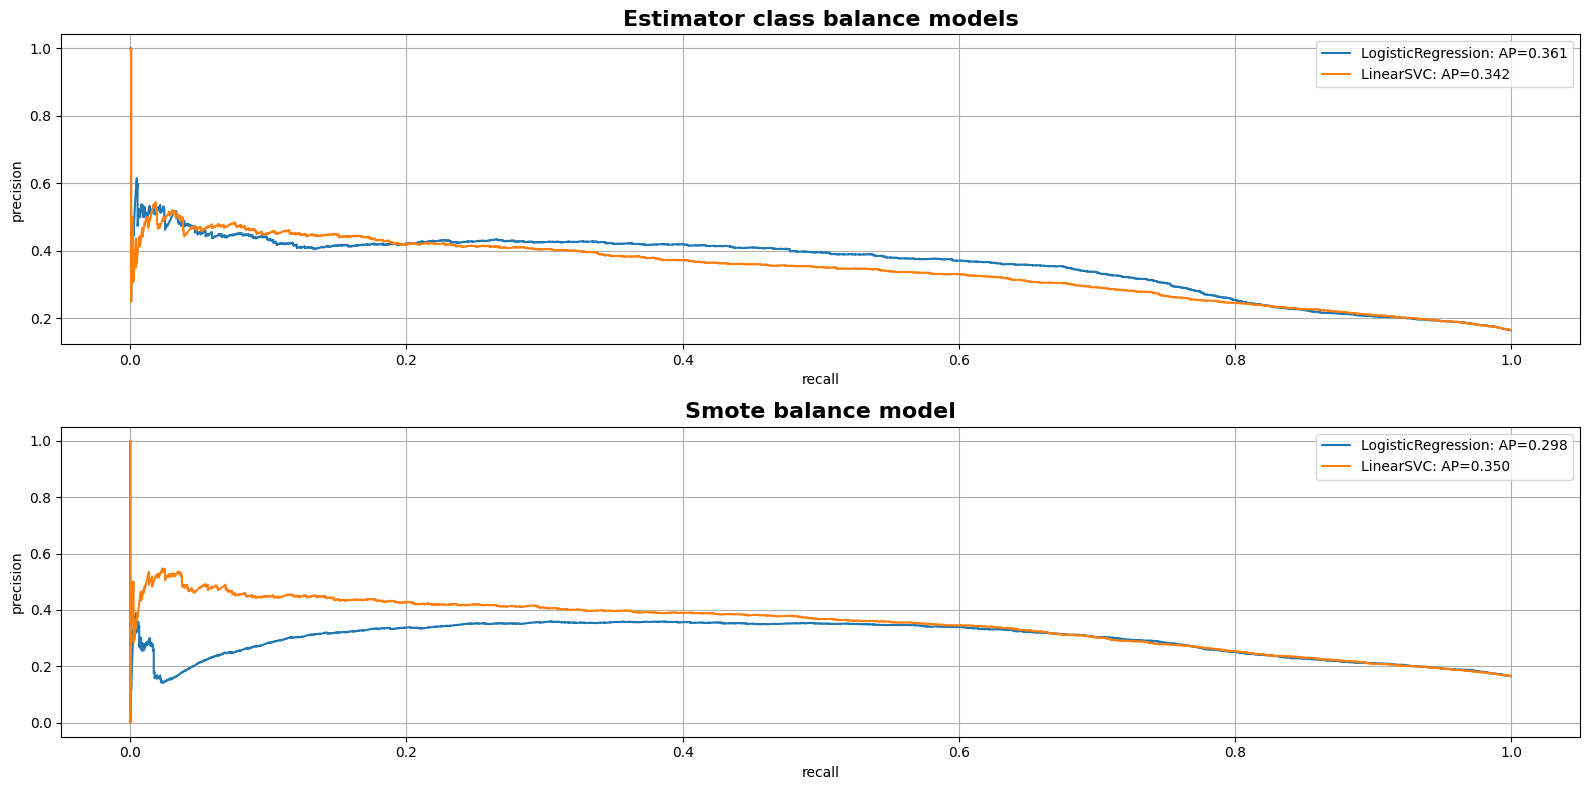

In [71]:
## fitting the numeric data set models
model_scores = defaultdict(list)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), layout='tight')

LR_balanced = Model(model=LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='logistic_regression', scale_column=['total_post_words'], ax=ax1, **best_lr_params)
                    
Lsvc_balanced = Model(model=LinearSVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='linear_svc', scale_column=['total_post_words'], ax=ax1, **lsvc_best_params)

LR_smote = Model(model=LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='logistic_regression', scale_column=['total_post_words'], smote=True, ax=ax2, **lr_smote_params)

Lsvc_smote = Model(model=LinearSVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='linear_svc', scale_column=['total_post_words'], smote=True, ax=ax2, **lsvc_smote_params)


models = {'lr_balanced':LR_balanced, 
          'lsvc_balanced': Lsvc_balanced, 
          'lr_smote':LR_smote, 
          'lsvc_smote':Lsvc_smote}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    for name, model in models.items():
        model_scores['model'].append(name)
        
        model.fit()
        recall, fscore, precision = model.model_score
        model_scores['recall'].append(recall)
        model_scores['fscore'].append(fscore)
        model_scores['precision'].append(precision)
    
        model.plot_recall

ax1.set_title('Estimator class balance models', fontsize=16, fontweight='bold')

ax2.set_title('Smote balance model', fontsize=16, fontweight='bold')

plt.show()
    

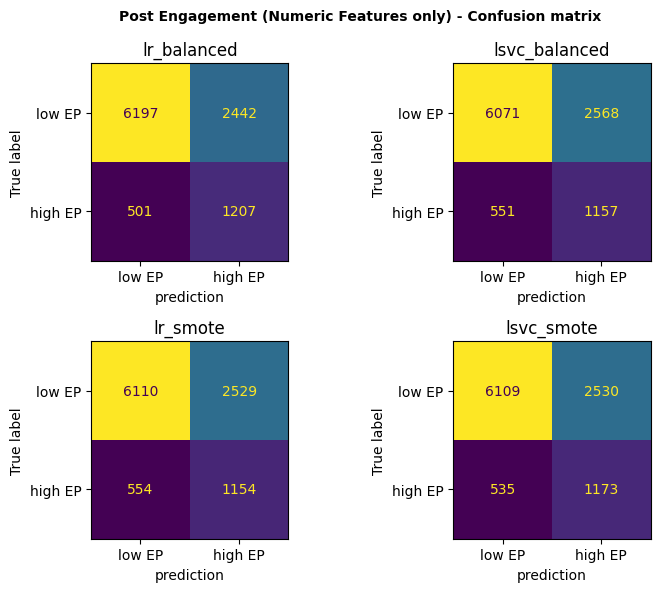

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), layout='tight')

axes = axes.ravel()

for (name, model), axd in zip((models.items()), axes):
    predicted = model.predict()

    plot_confusion_matrix(y= y_test, prediction=predicted, ax=axd, title=name) 

plt.subplots_adjust(top=0.7,hspace=0.2)
plt.suptitle('Post Engagement (Numeric Features only) - Confusion matrix', fontweight='bold', fontsize=10)
plt.show()
    

In [73]:
## Printing model results for numberic features only
pd.DataFrame(model_scores).set_index('model').T

model,lr_balanced,lsvc_balanced,lr_smote,lsvc_smote
recall,0.707,0.677,0.676,0.687
fscore,0.451,0.426,0.428,0.434
precision,0.331,0.311,0.313,0.317


#### Results of numeric data models
The logistic regression models performed similarly with linear SVC models in all the metrics. Using balanced class weight for the logistic regression has shown better model recall for the positive class compared to using SMOTE sampling for the dataset. The recall for class balance logistic regression performed quite well. However, the low precision shows that a significant number of the predicted class were incorrectly predicted positive class. The harmonic mean penalizes heavily the wrong predictions which is why the strong recall score did not reflect in the f1_score.  Based on the objective of finding high engagement posts, the precision=recall curve shows that as recall increases, the precision drops gradually. For the best performing model class-balance logistic regression, at very low recall, the precision was approximately 0.5 and dropped to about 0.4 as recall increases and reaching 0.3 when recall was 0.7. However, beyond 0.7 recall, the precision dropped significantly to 0.1 showing the model is unable to differentiate between low-engagement and high-engagemnent posts. 

The performance for the linear SVC is similar for both the class balance model and SMOTE sampling model as well. However, there is a slight increase in the metrics with the use of the SMOTE class balance.  Similar to the logistic regression, the precision, f1_score and recall follow the same pattern.

#### Modeling of text features using class balance and SMOTE. 
The same trained model will be used to model the text features.  For the text features, I will be preparing the data using TfidfVectorizer with unigrams and bigrams features.

In [74]:
post_df.head()

,post
0,winning pitcher
1,the three greatest martial artists ever
2,ufl week 9
3,so angel reese is 6 3 she is 4 for 19 when
4,caroline was the fav last night please explain


In [75]:
##preparing the data
post_df.head()

X_train, X_test, y_train, y_test = train_test_split(post_df['post'], y, test_size=0.25, stratify=y, random_state=22)

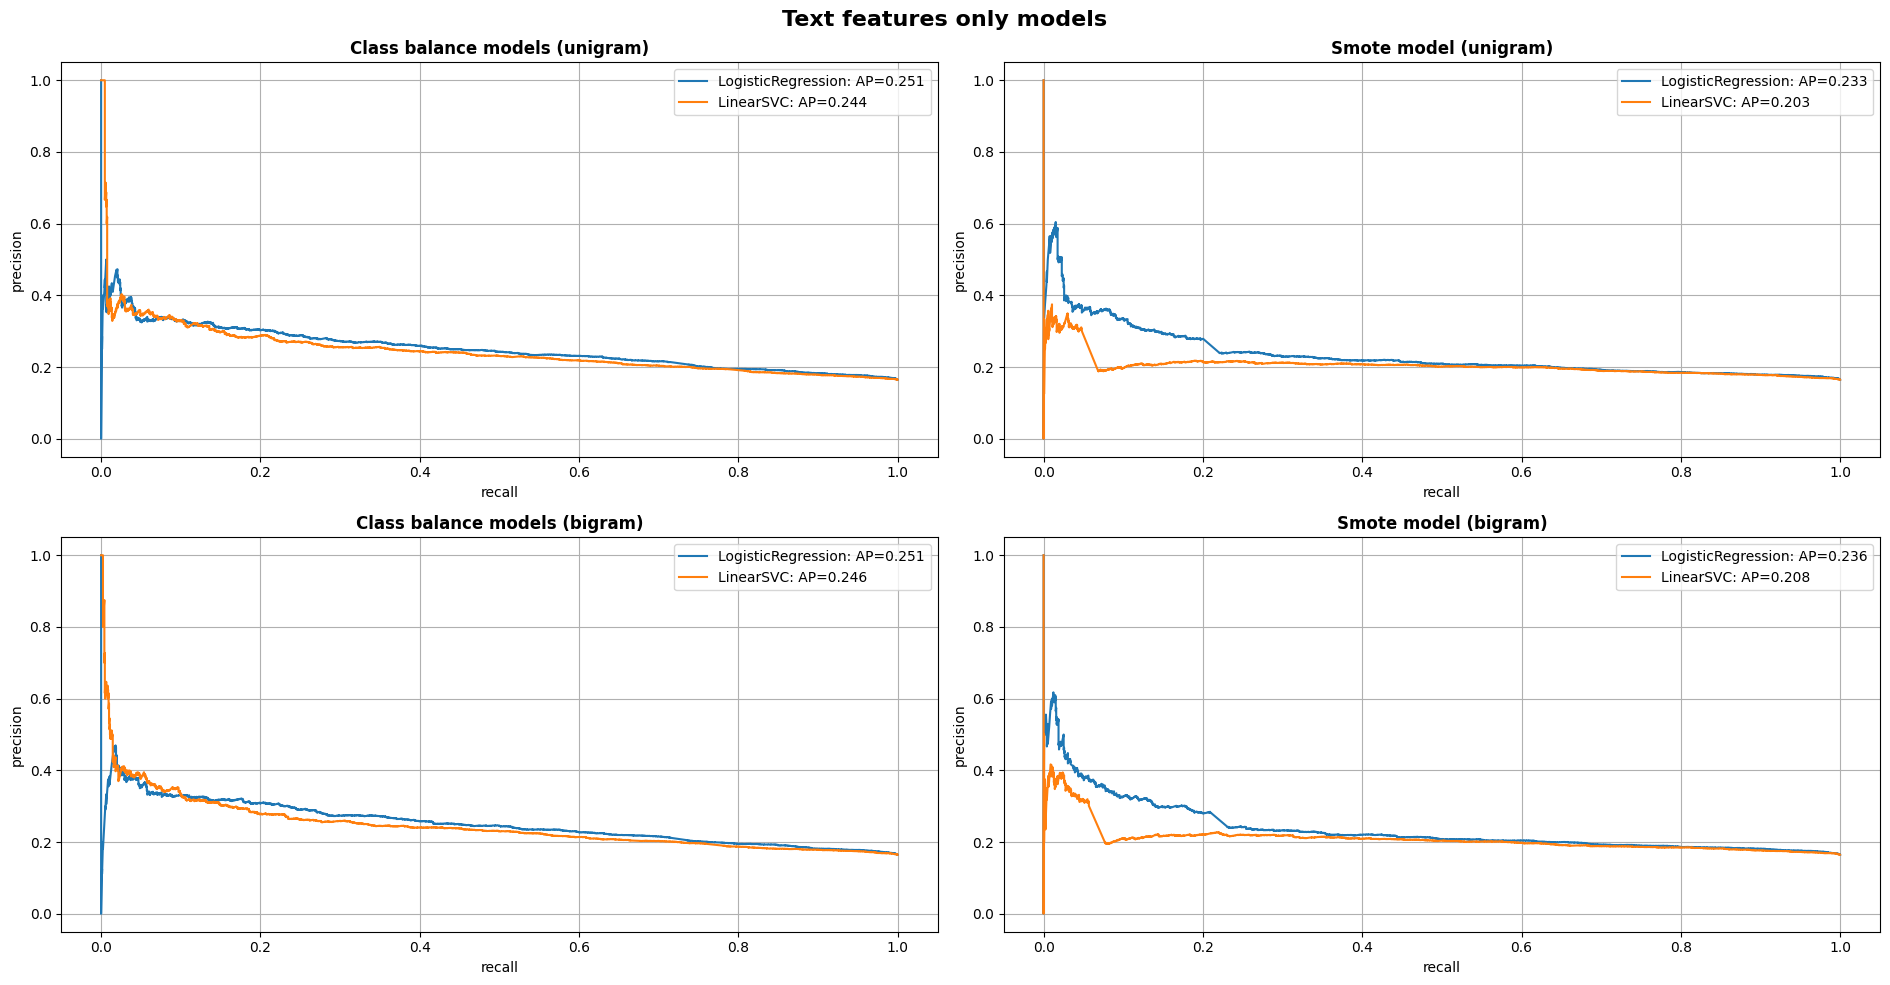

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(19, 10), layout='tight')

## preparing the models with unigram
LR_unigram_balanced = Model(model=LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='logistic_regression', vectorizer=True, ngrams=(1, 1), ax=ax1[0], **best_lr_params)
LSVC_unigram_balanced = Model(model=LinearSVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='linear_svc', vectorizer=True, ngrams=(1, 1), ax=ax1[0], **lsvc_best_params)
LR_unigram_smote = Model(model=LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='logistic_regression', vectorizer=True, ngrams=(1, 1), smote=True, ax=ax1[1], **lr_smote_params)
LSVC_unigram_smote = Model(model=LinearSVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='linear_svc', vectorizer=True, ngrams=(1, 1), smote=True, ax=ax1[1], **lsvc_smote_params)

## preparing the models with bigram
LR_bigram_balanced = Model(model=LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='logistic_regression', vectorizer=True, ngrams=(1, 2), ax=ax2[0], **best_lr_params)
LSVC_bigram_balanced = Model(model=LinearSVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='linear_svc', vectorizer=True, ngrams=(1, 2), ax=ax2[0], **lsvc_best_params)
LR_bigram_smote = Model(model=LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='logistic_regression', vectorizer=True, ngrams=(1, 2), smote=True, ax=ax2[1], **lr_smote_params)
LSVC_bigram_smote = Model(model=LinearSVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='linear_svc', vectorizer=True, ngrams=(1, 2), smote=True, ax=ax2[1], **lsvc_smote_params)


text_models = {'LR_unigram_balanced':LR_unigram_balanced, 
              'LSVC_unigram_balanced': LSVC_unigram_balanced, 
              'LR_unigram_smote':LR_unigram_smote, 
              'LSVC_unigram_smote':LSVC_unigram_smote,
               'LR_bigram_balanced': LR_bigram_balanced,
               'LSVC_bigram_balanced': LSVC_bigram_balanced,
               'LR_bigram_smote': LR_bigram_smote,
               'LSVC_bigram_smote': LSVC_bigram_smote
              }

    
for name, model in text_models.items():
    model_scores['model'].append(name)
        
    model.fit()
    recall, fscore, precision = model.model_score
    model_scores['recall'].append(recall)
    model_scores['fscore'].append(fscore)
    model_scores['precision'].append(precision)
    
    model.plot_recall
       
ax1[0].set_title('Class balance models (unigram)', fontsize=12, fontweight='semibold')
ax1[1].set_title('Smote model (unigram)', fontsize=12, fontweight='semibold')
ax2[0].set_title('Class balance models (bigram)', fontsize=12, fontweight='semibold')
ax2[1].set_title('Smote model (bigram)', fontsize=12, fontweight='semibold')

plt.suptitle('Text features only models', fontsize=16, fontweight='bold')
plt.show()

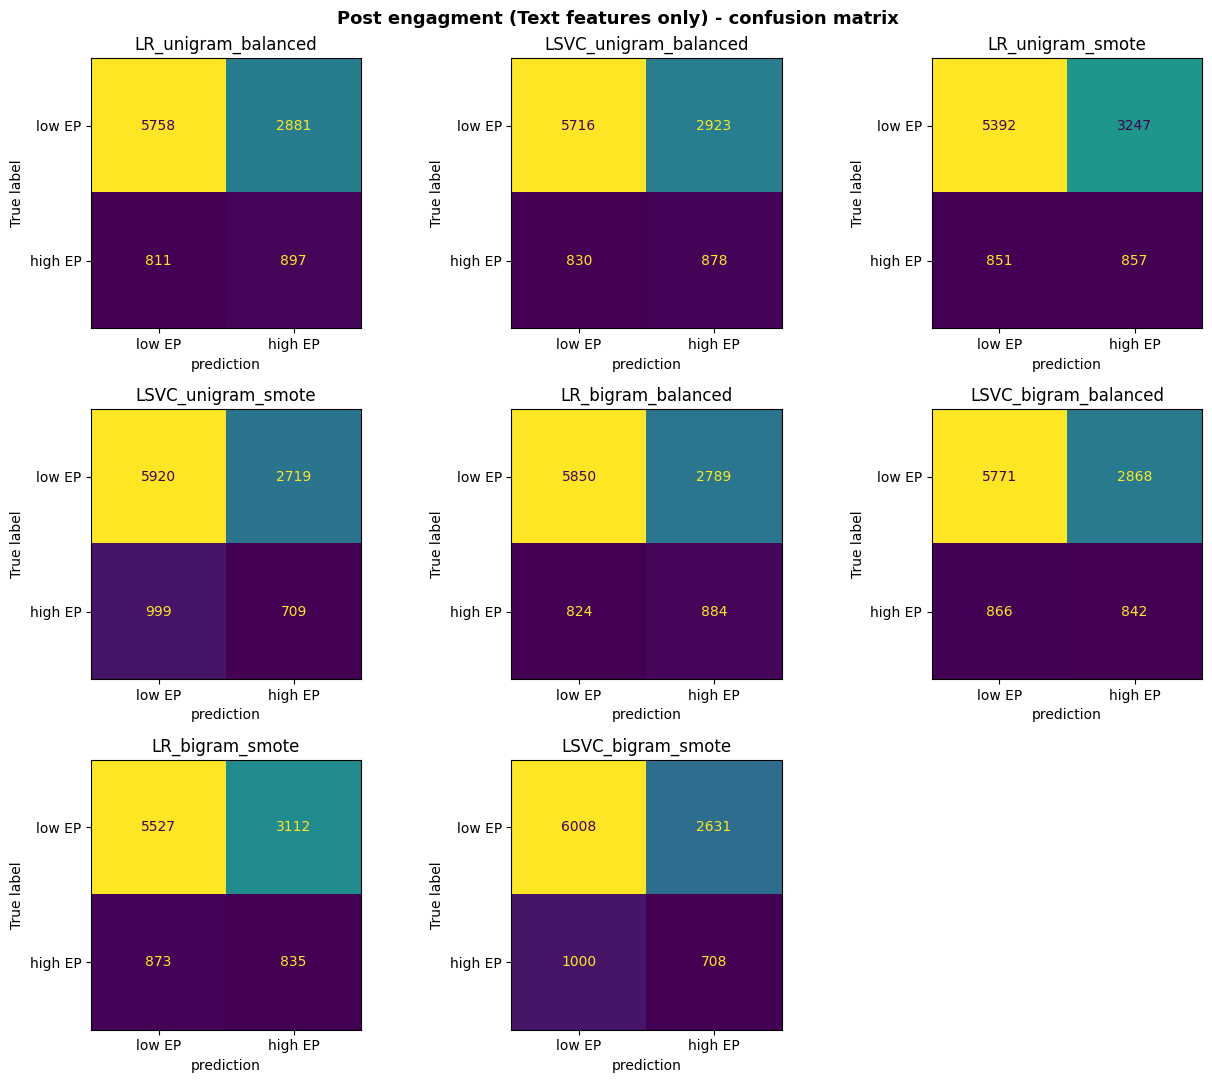

In [77]:
#plotting confusion matrix for text features only
fig  = plt.figure(figsize=(13, 11), layout='tight')

for (name, model), idx in zip(text_models.items(), range(8)):
    prediction = model.predict()
    axd = plt.subplot(3, 3, idx+1)

    plot_confusion_matrix(y_test, prediction,
                          ax=axd,
                          title = name)

plt.suptitle('Post engagment (Text features only) - confusion matrix', fontsize=13, fontweight='semibold')
plt.show()

In [78]:
# comparing the models metrics for text features only
pd.DataFrame(model_scores).set_index('model').iloc[4:]

,recall,fscore,precision
model,,,
LR_unigram_balanced,0.525,0.327,0.237
LSVC_unigram_balanced,0.514,0.319,0.231
LR_unigram_smote,0.502,0.295,0.209
LSVC_unigram_smote,0.415,0.276,0.207
LR_bigram_balanced,0.518,0.329,0.241
LSVC_bigram_balanced,0.493,0.311,0.227
LR_bigram_smote,0.489,0.295,0.212
LSVC_bigram_smote,0.415,0.281,0.212


##### Text features results summary
The overall performance of the text features only models is average. The performance between logistic regression and linear SVC, class-balance model and SMOTE models mimic the same pattern for the models using the numeric features only although the SMOTE class balance did not improve the performance of the text features. However, the unigram vectorized data scores were higher than that of the bigrams. As expected the number of features generated by bigram vectorized data is much more larger than the unigram features and this increases the complexities for the model generalisation which could account for the drop.  To investigate this, I will introduce dimensionality reduction and then use the class-balance  models parameters for unigram features. The class-balance models were the best performing models for the text features. 

In [79]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

In [80]:
class ModelLSA(Model):
    def __init__(self, n_components=100, *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        
        self.n_components = n_components


    def build_pipeline(self):
        if self.final_pipeline is None:
            self.processor = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+(?:-\w+)*\b",
                          ngram_range = self.ngrams,
                          min_df=5, max_df=0.8,
                          stop_words='english')

            self.final_pipeline = Pipeline([('processor', self.processor),
                                            ('SVD', TruncatedSVD(n_components=self.n_components,
                                                                n_iter=10,
                                                                random_state=9)),
                                            ('normalizer', Normalizer()),
                                            (self.model_name, self.model())
                                            ]).set_params(**self.params)
                
        return self.final_pipeline
        

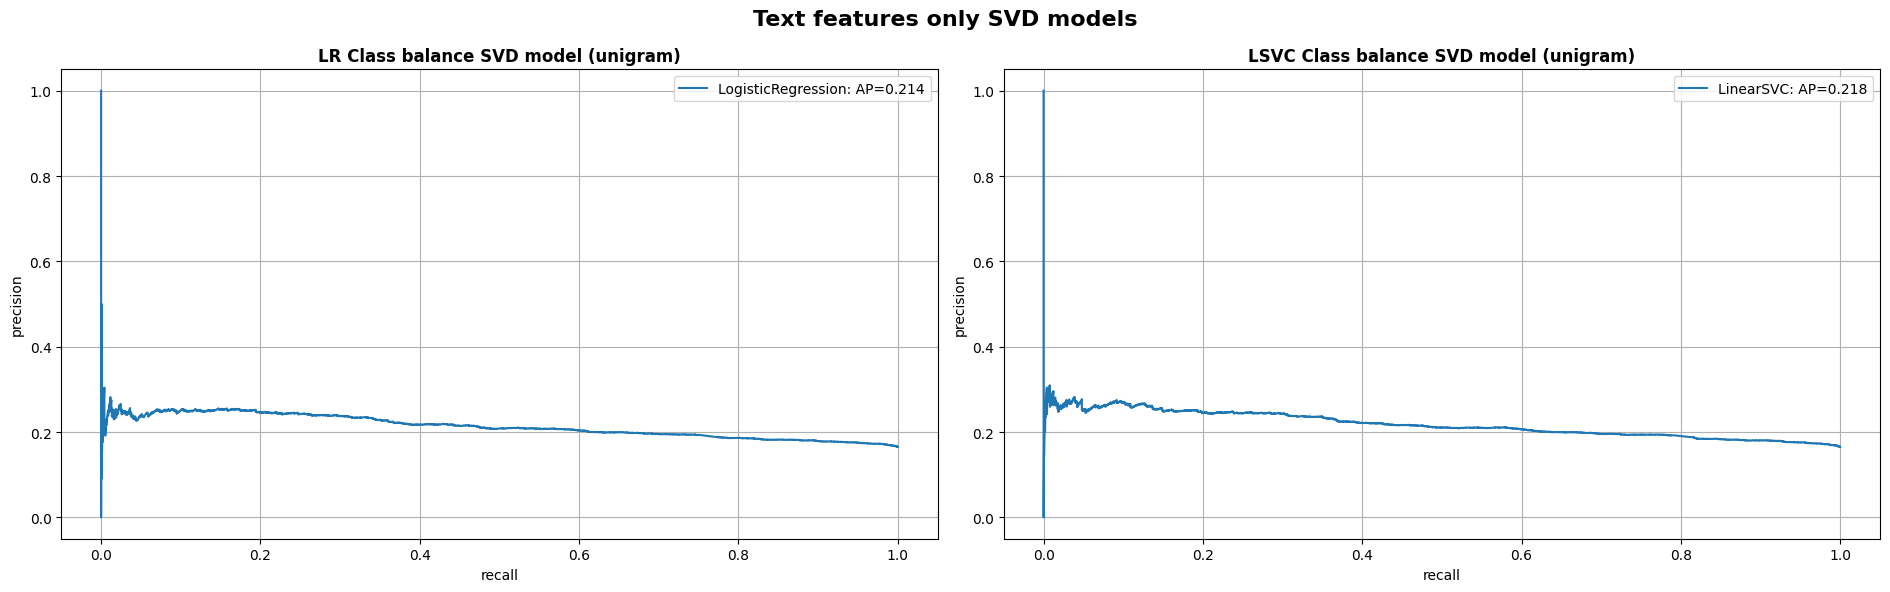

In [81]:
## dimensionality reduction 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 6), layout='tight')

LR_unigram_svd = ModelLSA(model=LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='logistic_regression', vectorizer=True, ngrams=(1, 1), ax=ax1, **best_lr_params)

LSVC_unigram_svd = ModelLSA(model=LinearSVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    model_name='linear_svc', vectorizer=True, ngrams=(1, 1), ax=ax2, **lsvc_best_params)


SVD_models = {'LR_unigram_svd': LR_unigram_svd,
              'LSVC_unigram_svd': LSVC_unigram_svd
            }

for name, model in SVD_models.items():
    model_scores['model'].append(name)
        
    model.fit()
    recall, fscore, precision = model.model_score
    model_scores['recall'].append(recall)
    model_scores['fscore'].append(fscore)
    model_scores['precision'].append(precision)
    
    model.plot_recall
       
ax1.set_title('LR Class balance SVD model (unigram)', fontsize=12, fontweight='semibold')

ax2.set_title('LSVC Class balance SVD model (unigram)', fontsize=12, fontweight='semibold')

plt.suptitle('Text features only SVD models', fontsize=16, fontweight='bold')
plt.show()

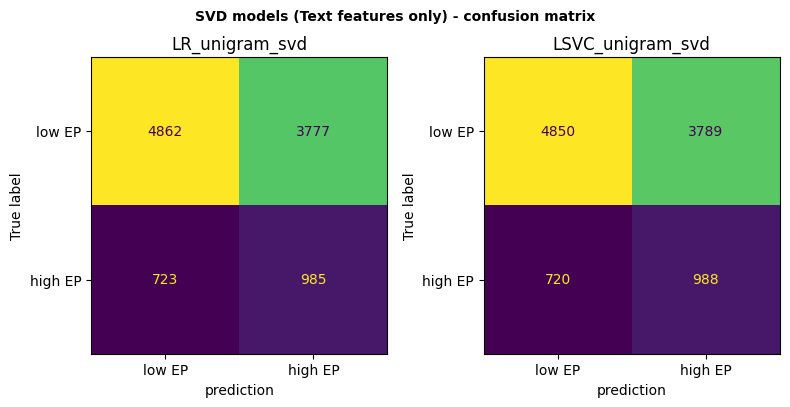

In [82]:
#plotting confusion matrix for text features only
fig  = plt.figure(figsize=(8, 4), layout='tight')

for (name, model), idx in zip(SVD_models.items(), range(2)):
    prediction = model.predict()
    axd = plt.subplot(1, 2, idx+1)

    plot_confusion_matrix(y_test, prediction,
                          ax=axd,
                          title = name)

plt.suptitle('SVD models (Text features only) - confusion matrix', fontsize=10, fontweight='semibold')
plt.show()

In [83]:
## Text features only data
pd.DataFrame(model_scores).set_index('model')[4:]

,recall,fscore,precision
model,,,
LR_unigram_balanced,0.525,0.327,0.237
LSVC_unigram_balanced,0.514,0.319,0.231
LR_unigram_smote,0.502,0.295,0.209
LSVC_unigram_smote,0.415,0.276,0.207
LR_bigram_balanced,0.518,0.329,0.241
LSVC_bigram_balanced,0.493,0.311,0.227
LR_bigram_smote,0.489,0.295,0.212
LSVC_bigram_smote,0.415,0.281,0.212
LR_unigram_svd,0.577,0.304,0.207


The SVD dimensionality reduction showed an improvement in recall however there is no corresponding improvement in precision and fscore, rather a decrease. This means that the dimensionality reduction improved the prediction of the positive class mostly when the negative class is minimal in the data. However once the negative class increase in the data, the model performance drops sharply.

### Comparison of the Numeric features models and text features models

In [84]:
pd.DataFrame(model_scores).set_index('model')

,recall,fscore,precision
model,,,
lr_balanced,0.707,0.451,0.331
lsvc_balanced,0.677,0.426,0.311
lr_smote,0.676,0.428,0.313
lsvc_smote,0.687,0.434,0.317
LR_unigram_balanced,0.525,0.327,0.237
LSVC_unigram_balanced,0.514,0.319,0.231
LR_unigram_smote,0.502,0.295,0.209
LSVC_unigram_smote,0.415,0.276,0.207
LR_bigram_balanced,0.518,0.329,0.241


Comparing the overall model performances between the `numeric features` only and `text features` only datasets:    
**Recall**: Based on recall, all the numeric features models scored higher than the text features. With introduction of dimensionality reduction in text features, the models improved in recall for text features. However, logistic regression scored higher overall. This means the logistic regression model has more sensitivity for the positive dataset than linearSVC. 

**Precision**: Precision was higher in numeric features than text only features. The precision was similar between both estimators for each set of features.  This means that with numeric features only, the predicted false positive is less than text features only. 

**F1_score**: The f1_score models are relatively higher also for numeric features.  F1_score is the harmonic mean that penalizes extreme values heavily ensuring that both recall and precision scores are high in order to score high F1_score. 

### Combining Text and Numeric featues for modelling. 
The class-balance models performed better than the SMOTE balance models overall. Therefore in this final model which combines the numeric features and text features together to evaluate if there is an improvement in the model performances, I shall be using only class balance models for the data.  Also, the unigram text features scored higher than the bigram features, therefore only unigram TfidfVectorizer will be used.  
Both the class balance Logistic regression and linear SVC models will be used.  Dimensionality reduction has shown to improve the model scores therefore, I will model the data using logistic regression and Linear SVC with and without dimensionality reduction. 

In [85]:
from sklearn.preprocessing import FunctionTransformer

In [86]:
### retrieving the prepared dataframe
model_df.head()

,post,year,quarter,month,day_of_week,hour,is_month_start,is_month_end,is_weekend,is_businessday,total_post_words
0,winning pitcher,2025,2,5,5,7,0,0,1,0,2
1,the three greatest martial artists ever,2025,2,5,4,23,0,0,0,1,6
2,ufl week 9,2025,2,5,4,17,0,0,0,1,3
3,so angel reese is 6 3 she is 4 for 19 when,2025,2,5,4,13,0,0,0,1,12
4,caroline was the fav last night please explain,2025,2,5,4,6,0,0,0,1,8


In [87]:
## function to handle the text data
def squeeze_to_1d(X):
    return X.squeeze()


class MultiModal(Model):
    def __init__(self, n_components=100, text_column=None, reduce_dim=False, *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        
        self.n_components = n_components
        self.text_column = text_column
        self.reduce_dim = reduce_dim
        


    def build_pipeline(self):
        if self.final_pipeline is None:
    
            self.vect_pipe = Pipeline([
                ('to_1d', FunctionTransformer(squeeze_to_1d, validate=False)),
                ('tfidf', TfidfVectorizer(token_pattern=r"(?u)\b\w\w+(?:-\w+)*\b",
                                          ngram_range = self.ngrams,
                                          min_df=5, max_df=0.8,
                                          stop_words='english'))]
                                         )

            if self.reduce_dim:
                
                self.processor_pipe = Pipeline([('vectorizer', self.vect_pipe),
                                               ('SVD', TruncatedSVD(n_components=self.n_components,
                                                                    n_iter=10,
                                                                    random_state=9)), 
                                               ('normalizer', Normalizer())]
                                             )
                
                self.processor = ColumnTransformer([('scaler', StandardScaler(), self.scale_column),
                                                    ('vectorizer', self.processor_pipe, self.text_column)],
                                                    remainder = 'passthrough', 
                                                   verbose_feature_names_out=False
                                                  )

            else:
                self.processor = ColumnTransformer([('scaler', StandardScaler(), self.scale_column),
                                                    ('vectorizer', self.vect_pipe, self.text_column)],
                                                    remainder = 'passthrough',
                                                   verbose_feature_names_out=False
                                                  )
            

            self.final_pipeline = Pipeline([('processor', self.processor),
                                            (self.model_name, self.model())
                                            ]).set_params(**self.params)
                
        return self.final_pipeline

   

In [88]:
### preparing the data 
X_train, X_test, y_train, y_test = train_test_split(model_df, y, test_size=0.25, stratify=y, random_state=3)

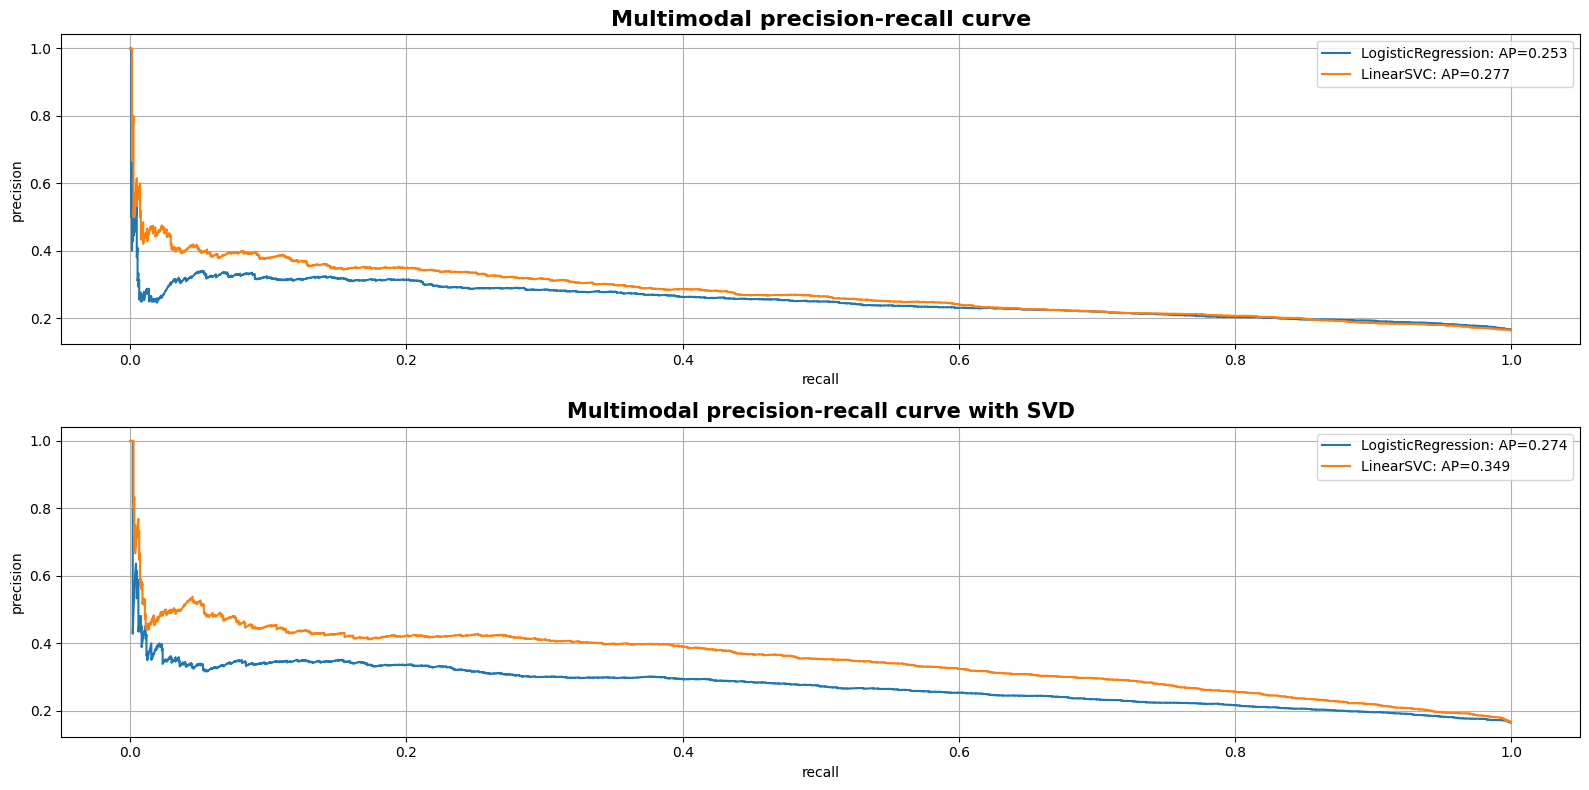

In [89]:
## the mix model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), layout='tight')


LR_multimodal = MultiModal(model=LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                        model_name='logistic_regression', scale_column=['total_post_words'], text_column='post', 
                         reduce_dim=False, ngrams=(1, 1), ax=ax1, **best_lr_params)

LSVC_multimodal = MultiModal(model=LinearSVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                        model_name='linear_svc', scale_column=['total_post_words'], text_column='post', 
                         reduce_dim=False, ngrams=(1, 1), ax=ax1, **lsvc_best_params)

LR_multimodal_svd = MultiModal(model=LogisticRegression, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                        model_name='logistic_regression', scale_column=['total_post_words'], text_column='post', 
                         reduce_dim=True, ngrams=(1, 1), ax=ax2, **best_lr_params)

LSVC_multimodal_svd= MultiModal(model=LinearSVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                        model_name='linear_svc', scale_column=['total_post_words'], text_column='post', 
                         reduce_dim=True, ngrams=(1, 1), ax=ax2, **lsvc_best_params)

multimodal = {'LR_multimodal' : LR_multimodal,
              'LSVC_multimodal': LSVC_multimodal,
              'LR_multimodal_svd': LR_multimodal_svd,
              'LSVC_multimodal_svd': LSVC_multimodal_svd
             }
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    for name, model in multimodal.items():
        model_scores['model'].append(name)
            
        model.fit()
        recall, fscore, precision = model.model_score
        model_scores['recall'].append(recall)
        model_scores['fscore'].append(fscore)
        model_scores['precision'].append(precision)
        
        model.plot_recall
           
ax1.set_title('Multimodal precision-recall curve', fontsize=16, fontweight='semibold')

ax2.set_title('Multimodal precision-recall curve with SVD', fontsize=15, fontweight='semibold')

plt.show()

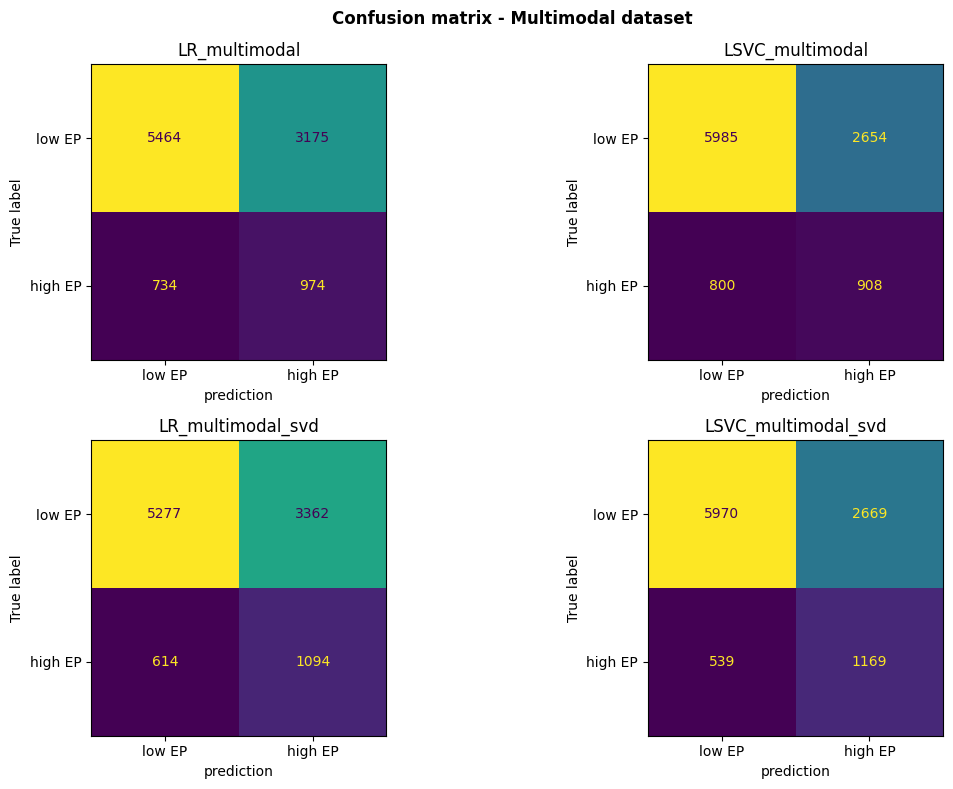

In [90]:
## plotting the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 8), layout='tight')
axes = axes.ravel()

for (name, model), ax in zip(multimodal.items(), axes):
    
    prediction = model.predict()
    
    plot_confusion_matrix(y_test, prediction, ax=ax, title=name)

plt.suptitle('Confusion matrix - Multimodal dataset', fontweight='bold')

plt.show()

In [91]:
model_results_df = pd.DataFrame(model_scores).set_index('model')
model_results_df

,recall,fscore,precision
model,,,
lr_balanced,0.707,0.451,0.331
lsvc_balanced,0.677,0.426,0.311
lr_smote,0.676,0.428,0.313
lsvc_smote,0.687,0.434,0.317
LR_unigram_balanced,0.525,0.327,0.237
LSVC_unigram_balanced,0.514,0.319,0.231
LR_unigram_smote,0.502,0.295,0.209
LSVC_unigram_smote,0.415,0.276,0.207
LR_bigram_balanced,0.518,0.329,0.241


In [92]:
model_results_df.T

model,lr_balanced,lsvc_balanced,lr_smote,lsvc_smote,LR_unigram_balanced,LSVC_unigram_balanced,LR_unigram_smote,LSVC_unigram_smote,LR_bigram_balanced,LSVC_bigram_balanced,LR_bigram_smote,LSVC_bigram_smote,LR_unigram_svd,LSVC_unigram_svd,LR_multimodal,LSVC_multimodal,LR_multimodal_svd,LSVC_multimodal_svd
recall,0.707,0.677,0.676,0.687,0.525,0.514,0.502,0.415,0.518,0.493,0.489,0.415,0.577,0.578,0.570,0.532,0.641,0.684
fscore,0.451,0.426,0.428,0.434,0.327,0.319,0.295,0.276,0.329,0.311,0.295,0.281,0.304,0.305,0.333,0.345,0.355,0.422
precision,0.331,0.311,0.313,0.317,0.237,0.231,0.209,0.207,0.241,0.227,0.212,0.212,0.207,0.207,0.235,0.255,0.246,0.305


### Performance comparisons between Numeric only, Text only and Multimodal features
The results dataframe for all models using numeric, text and multimodal features have shown that using numeric features alone, the two models were able to classify posts better than all other type of features. Scores for recall remained above 0.67, precision at 0.3 and f1_score at 0.4.  Text features only classification results were poorer and only improved with the introduction dimensionality reduction.     

**Did the text features improve the data?** Combining of the text features with the numeric features did not improve the performance of the numeric only features. Although it can be seen that performance of the multimodal features did improve with dimensionality reduction, however, these improvement is inconsistent with the metrics because, although the recall score improved, there was no balanced consistent improvement on precision and f1_score for logisitic regression.

It is important that with the introduction of the text features to the numeric features and following vectorisation of the text feautures with gave rise to sparse matrix, the number of features for the linear models expanded significantly. Linear models are very good at generalising data however, when the number of features are above certain threshold (approximately 10 - 20), the models generalisation drops with increasing features. Also, it is important the note that both linear models are using L2 regularisation which unlike L1 regularisation, does not drive most of the coefficients of the data to zero. Therefore, with increase features also come increase in complexity and poor generalisation of the data by the models.

##### Coefficients of class balance linear regression and SMOTE linear SVC with numeric features only
In this final stage, I will like to quickly look at the coefficients of the best performing models for the numeric features. These two models are:
1. Class balance logistic regression and
2. SMOTE balance Linear SVC

In [93]:
LR_model = LR_balanced.build_pipeline()
LR_coef = LR_model.named_steps['logistic_regression'].coef_.ravel()

LSVC_model = Lsvc_smote.build_pipeline()
Lsvc_coef = LSVC_model.named_steps['linear_svc'].coef_.ravel()

features = num_df.columns 

coef = {'features' : features,
      'logistic R coef': np.round(LR_coef, 3),
      'Linear SVC coef': np.round(Lsvc_coef, 3)
     }

coef_df = pd.DataFrame(coef).set_index('features')

coef_df

,logistic R coef,Linear SVC coef
features,,
year,0.138,0.097
quarter,0.220,0.057
month,-0.020,0.008
day_of_week,0.027,0.002
hour,-0.027,-0.015
is_month_start,-0.041,-0.019
is_month_end,-0.081,-0.129
is_weekend,-0.037,-0.129
is_businessday,-0.321,-38.143


For the logistic regression, the three biggest features impacting the model predictions are quarter and year which have positive impact and is it a businessday which have a very strong negative impact on the classification.    
For the linearSVC model, the two biggest features impactive the model predictions are the total post words and is it a businessday. These two have a super strong impact on the model classification. The year is the next coefficient which has a positive impact although not a very strong impact.  
Evidently from the two models, posting on a businessday has a negative impact on prediction, however this effect is very strong for linear svc compared to logistic regression. 
It is worth noting that the coeficients of the features in logistic regression are more spread out without a singular feature dominating the classification equation.  This is not however the case with linear SVC. bussinessday and total post words dominated the rest of the features on impact. Of particular interest is the total_post_words. The coeficient shows that the higher the number of words in the post, the stronger the effect on classification.

## Conclusion
In this notebook, i classified high and low engagment posts with Logistic regression and linear SVC models using only numeric features, text features and combination of numeric and text feaures. The result show that the models are able to classify posts better with only numeric features than when combined with text features. 